In [1]:
import dropbox
import urllib.request, json 
from collections import defaultdict
from collections import OrderedDict
import datetime as DT
import ast
from __future__ import print_function
from __future__ import division
import collections
import nltk
import numpy as np
from string import punctuation
import csv
from nltk.tokenize.treebank import TreebankWordTokenizer
tokenizer = TreebankWordTokenizer()

# Helper libraries
from w266_common import utils, vocabulary

########################### DLEE IMPORTS ##################################

# Import pandas and tensorflow
import pandas as pd
import tensorflow as tf
assert(tf.__version__.startswith("1.10"))

# Import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# Import model
import models

# Import misc
from importlib import reload
import os, sys, re, json, time, datetime, shutil
import itertools
from w266_common import patched_numpy_io

/home/danlee85/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# ##Download the pre-processed tweets from dropbox

# access_token = 'p3Ze8FpdRTAAAAAAAAAADb9hCQ8aXXYU3A3gGM1HEXyeMrs8KI2SrA71KDmmCXte'
# dbx = dropbox.Dropbox(access_token)
# metadata, res = dbx.files_download(path="/Inputdata2.txt")


# access_token2 = 'm_fKi8mWZ0AAAAAAAAAADlfzTm37f1y45k92Xpiw1B6mjT3dQqzNvKgpIUSR17uq'
# dbx2 = dropbox.Dropbox(access_token2)

# #Write the combined file into the drive
# with open("InputX.txt", "wb") as f:
#     metadata, res = dbx.files_download(path="/Inputdata2.txt")
#     metadata2, res2 = dbx2.files_download(path="/Inputdata.txt")
#     f.write(res.content)
#     f.write(res2.content)

In [3]:
##Translate date of the tweet to quarter reference
def Quarterlookup(date):
    if date>=DT.datetime(2018,10,1):
        return '18Q4'
    elif date>=DT.datetime(2018,7,1):
        return '18Q3'
    elif date>=DT.datetime(2018,4,1):
        return '18Q2'
    elif date>=DT.datetime(2018,1,1):
        return '18Q1'
    elif date>=DT.datetime(2017,10,1):
        return '17Q4'
    elif date>=DT.datetime(2017,7,1):
        return '17Q3'
    elif date>=DT.datetime(2017,4,1):
        return '17Q2'
    elif date>=DT.datetime(2017,1,1):
        return '17Q1'
    elif date>=DT.datetime(2016,10,1):
        return '16Q4'
    elif date>=DT.datetime(2016,7,1):
        return '16Q3'
    elif date>=DT.datetime(2016,4,1):
        return '16Q2'
    elif date>=DT.datetime(2016,1,1):
        return '16Q1'
    elif date>=DT.datetime(2015,10,1):
        return '15Q4'
    elif date>=DT.datetime(2015,7,1):
        return '15Q3'
    elif date>=DT.datetime(2015,4,1):
        return '15Q2'
    else:
        return '15Q1'

In [4]:
# map financials to same date-key as tweets
def Quarterlookup_2(date):
    if date<=DT.datetime(2014,12,31):
        return '14Q4'
    elif date<=DT.datetime(2015,3,31):
        return '15Q1'
    elif date<=DT.datetime(2015,6,30):
        return '15Q2'
    elif date<=DT.datetime(2015,9,30):
        return '15Q3'
    elif date<=DT.datetime(2015,12,31):
        return '15Q4'
    elif date<=DT.datetime(2016,3,31):
        return '16Q1'
    elif date<=DT.datetime(2016,6,30):
        return '16Q2'
    elif date<=DT.datetime(2016,9,30):
        return '16Q3'
    elif date<=DT.datetime(2016,12,31):
        return '16Q4'
    elif date<=DT.datetime(2017,3,31):
        return '17Q1'
    elif date<=DT.datetime(2017,6,30):
        return '17Q2'
    elif date<=DT.datetime(2017,9,30):
        return '17Q3'
    elif date<=DT.datetime(2017,12,31):
        return '17Q4'
    elif date<=DT.datetime(2018,3,31):
        return '18Q1'
    elif date<=DT.datetime(2018,6,30):
        return '18Q2'
    else:
        return '18Q3'

In [5]:
print(Quarterlookup(DT.datetime.strptime('9/30/2018', '%m/%d/%Y')))
DT.datetime.strptime('9/30/2018', '%m/%d/%Y')

18Q3


datetime.datetime(2018, 9, 30, 0, 0)

In [6]:
print(Quarterlookup_2(DT.datetime.strptime('9/30/2018', '%m/%d/%Y')))
DT.datetime.strptime('9/30/2018', '%m/%d/%Y')

18Q3


datetime.datetime(2018, 9, 30, 0, 0)

In [7]:
print(Quarterlookup(DT.datetime.strptime('4/30/2018', '%m/%d/%Y')))
DT.datetime.strptime('9/30/2018', '%m/%d/%Y')

18Q2


datetime.datetime(2018, 9, 30, 0, 0)

In [8]:
print(Quarterlookup_2(DT.datetime.strptime('4/30/2018', '%m/%d/%Y')))
DT.datetime.strptime('9/30/2018', '%m/%d/%Y')

18Q2


datetime.datetime(2018, 9, 30, 0, 0)

In [9]:
##Reading the Input X file and process it
d=defaultdict(list)

with open('InputX.txt') as f:
    for line in f:
        count=0
        temp =-1
        k,v=line.split(':',1)
        while True:
            
            oldtemp=temp
            temp=v.find(']]',temp+1)
            if count==0:
                d[k].append(v[oldtemp+2:temp+2]) 
            else:
                d[k].append(v[oldtemp+4:temp+2])
           
             
            count+=1
            if temp == -1: break
#             if count == 500: break  # initially limit for time sake
    

In [10]:
keys = list(d.keys())

In [11]:
d[keys[0]]

["[datetime.date(2018, 3, 20), ['builders', 'first', 'source', 'farmingdale', 'ny', 'not', 'only', 'collects', 'toys', 'for', 'tots', 'but', 'also', 'sells', 'zip', 'stretch', 'tape', 'and', 'uses', 'it', 'everywhere', '!', 'don', '’', 't', 'forget', 'to', 'bring', 'a', 'toy', 'when', 'you', 'are', 'in', 'their', 'store', 'to', 'buy', 'huber', 'products', '!', '#', 'huberwood', '#', 'buildersfirstsource', '#', 'toysfortots', 'samples/lit', 'from', '@', 'muggsli', 'pic.twitter.com/icr5aihrsg']]",
 "[datetime.date(2018, 1, 16), ['builders', 'first', 'source', 'to', 'close', 'east', 'hartford', 'location', 'http', ':', '//www.', 'journalinquirer.com/business/build', 'ers-first-source-to-close/article_1011720a-dd22-11e8-b2f7-7b00c9795d8a.html', '?', 'utm_medium=social', '&', 'utm_source=twitter', '&', 'utm_campaign=user-share', '…', '#', 'ctnews', '#', 'buildersfirstsource', '#', 'easthartfordct']]",
 "[datetime.date(2016, 8, 4), ['a', 'great', 'time', 'was', 'had', 'by', 'all', 'at', 'the

In [12]:
d[keys[0]][0]

"[datetime.date(2018, 3, 20), ['builders', 'first', 'source', 'farmingdale', 'ny', 'not', 'only', 'collects', 'toys', 'for', 'tots', 'but', 'also', 'sells', 'zip', 'stretch', 'tape', 'and', 'uses', 'it', 'everywhere', '!', 'don', '’', 't', 'forget', 'to', 'bring', 'a', 'toy', 'when', 'you', 'are', 'in', 'their', 'store', 'to', 'buy', 'huber', 'products', '!', '#', 'huberwood', '#', 'buildersfirstsource', '#', 'toysfortots', 'samples/lit', 'from', '@', 'muggsli', 'pic.twitter.com/icr5aihrsg']]"

In [13]:
d[keys[0]][0][0]

'['

In [14]:
#Read from the vocab file pre prepared
with open('vocab.csv', 'r') as f:
    reader = csv.reader(f,delimiter=';')
    allword = set(list(reader)[0])

In [15]:
allword=sorted(allword)
vocab = vocabulary.Vocabulary(allword, size=None)  # size=None means unlimited
print("Vocabulary size: {:,}".format(vocab.size))

Vocabulary size: 5,681


In [16]:
def pad_np_array(example_ids, max_len=50, pad_id=0):

    arr = np.full([len(example_ids), max_len], pad_id, dtype=np.int32)
    ns = np.zeros([len(example_ids)], dtype=np.int32)
    cpy_len = min(len(example_ids), max_len)

    arr = example_ids[:cpy_len]
    ns = cpy_len
    return arr, ns

In [17]:
#Dictionary to collect the tweet detail and the length of each tweet
InputX=defaultdict(dict)
InputN=defaultdict(dict)

In [18]:
#Set of all the stocks of interest
trainstock =['CVSHealth', 'RiteAid', "Conn's", "Casey's", 'Kroger','WeisMarkets', 'HavertyFurniture', "Kirkland's", 'Pier1Imports', 'BuildersFirstSource', 'HuttigBuildingProducts', 'LumberLiquidators', 'TransWorldEntertainment', 'MarineMax', 'Medifast', 'SallyBeauty',"Sotheby's", 'StarGasPartners', 'SuburbanPropanePartners', 'TitanMachinery', 'TractorSupply', 'TravelCentersofAmerica', 'Big5SportingGoods', "Dick'sSportingGoods", 'HibbettSports', 'Build-A-BearWorkshop']

# trainstock =["Conn's"]

In [19]:
##Converting the string of data into dictionary


for key,value in d.items():
    Inputx=defaultdict(list)
    Inputn=defaultdict(list)
    if key in trainstock:
        for value2 in value:
        
            temp=value2.find('), ')
            date=value2[14:temp+3]
            try:
                year=int(date[1:5])
                month=int(date[date.find(',')+2:date.find(',',date.find(',')+1)])
                day=int(date[date.find(')')-2:date.find(')')])
            
                sentence, length = pad_np_array (vocab.words_to_ids(ast.literal_eval(value2[temp+3:-1])))
            
                Inputx[Quarterlookup(DT.datetime(year,month,day))].append(sentence)
                Inputn[Quarterlookup(DT.datetime(year,month,day))].append(length)
            except:
                pass

    InputX[key]=OrderedDict(sorted(Inputx.items()))
    InputN[key]=OrderedDict(sorted(Inputn.items()))

In [20]:
##List of stockname and relevant stock code
l = [("CVSHealth", "CVS"),
("RiteAid", "RAD"),
("Conn's", "CONN"),
("Casey's", "CASY"),
("Kroger", "KR"),
("WeisMarkets", "WMK"),
("HavertyFurniture", "HVT"),
("Kirkland's", "KIRK"),
("Pier1Imports","PIR"),
("BuildersFirstSource","BLDR"),
("HuttigBuildingProducts", "HBP"),
("LumberLiquidators", "LL"),
("TransWorldEntertainment", "TWMC"),
("MarineMax", "HZO"),
("Medifast", "MED"),
("SallyBeauty", "SBH"),
("Sotheby's", "BID"),
("StarGasPartners", "SGU"),
("SuburbanPropanePartners", "SPH"),
("TitanMachinery", "TITN"),
("TractorSupply","TSCO"),
("TravelCentersofAmerica", "TA"),
("Big5SportingGoods", "BGFV"),
("Dick'sSportingGoods", "DKS"),
("HibbettSports", "HIBB"),
("Build-A-BearWorkshop", "BBW")]
     
all_stock = {}
[all_stock.update({k:v}) for k,v in l]
print(all_stock)

{'CVSHealth': 'CVS', 'RiteAid': 'RAD', "Conn's": 'CONN', "Casey's": 'CASY', 'Kroger': 'KR', 'WeisMarkets': 'WMK', 'HavertyFurniture': 'HVT', "Kirkland's": 'KIRK', 'Pier1Imports': 'PIR', 'BuildersFirstSource': 'BLDR', 'HuttigBuildingProducts': 'HBP', 'LumberLiquidators': 'LL', 'TransWorldEntertainment': 'TWMC', 'MarineMax': 'HZO', 'Medifast': 'MED', 'SallyBeauty': 'SBH', "Sotheby's": 'BID', 'StarGasPartners': 'SGU', 'SuburbanPropanePartners': 'SPH', 'TitanMachinery': 'TITN', 'TractorSupply': 'TSCO', 'TravelCentersofAmerica': 'TA', 'Big5SportingGoods': 'BGFV', "Dick'sSportingGoods": 'DKS', 'HibbettSports': 'HIBB', 'Build-A-BearWorkshop': 'BBW'}


In [22]:
top="http://datafied.api.edgar-online.com/v2/corefinancials/qtr?primarysymbols="
bottom="&appkey=asc97xrhkyu4959aptu76zxj"
Outputy =defaultdict(dict)
for stockname,stock in all_stock.items():
    check=top+stock+bottom
    with urllib.request.urlopen(check) as url:
        data = json.loads(url.read().decode())

In [23]:
print(type(data))
print(len(data))
print(data)

<class 'dict'>
1
{'result': {'totalrows': 16, 'rows': [{'rownum': 1, 'values': [{'field': 'taxonomyid', 'value': 50}, {'field': 'cik', 'value': '0001113809'}, {'field': 'companyname', 'value': 'BUILD A BEAR WORKSHOP INC'}, {'field': 'entityid', 'value': 146361}, {'field': 'primaryexchange', 'value': 'NYSE'}, {'field': 'marketoperator', 'value': 'NYSE'}, {'field': 'markettier', 'value': 'NYSE'}, {'field': 'primarysymbol', 'value': 'BBW'}, {'field': 'siccode', 'value': '5945'}, {'field': 'sicdescription', 'value': 'Retail-Hobby, Toy and Game Shops'}, {'field': 'usdconversionrate', 'value': 1.0}, {'field': 'restated', 'value': False}, {'field': 'receiveddate', 'value': '11/29/2018'}, {'field': 'preliminary', 'value': True}, {'field': 'periodlengthcode', 'value': 'm'}, {'field': 'periodlength', 'value': 3}, {'field': 'periodenddate', 'value': '11/3/2018'}, {'field': 'original', 'value': True}, {'field': 'formtype', 'value': '8-K'}, {'field': 'fiscalyear', 'value': 0}, {'field': 'fiscalquar

In [24]:
print(type(data['result']))
print(len(data['result']))
print(data['result'])

<class 'dict'>
2
{'totalrows': 16, 'rows': [{'rownum': 1, 'values': [{'field': 'taxonomyid', 'value': 50}, {'field': 'cik', 'value': '0001113809'}, {'field': 'companyname', 'value': 'BUILD A BEAR WORKSHOP INC'}, {'field': 'entityid', 'value': 146361}, {'field': 'primaryexchange', 'value': 'NYSE'}, {'field': 'marketoperator', 'value': 'NYSE'}, {'field': 'markettier', 'value': 'NYSE'}, {'field': 'primarysymbol', 'value': 'BBW'}, {'field': 'siccode', 'value': '5945'}, {'field': 'sicdescription', 'value': 'Retail-Hobby, Toy and Game Shops'}, {'field': 'usdconversionrate', 'value': 1.0}, {'field': 'restated', 'value': False}, {'field': 'receiveddate', 'value': '11/29/2018'}, {'field': 'preliminary', 'value': True}, {'field': 'periodlengthcode', 'value': 'm'}, {'field': 'periodlength', 'value': 3}, {'field': 'periodenddate', 'value': '11/3/2018'}, {'field': 'original', 'value': True}, {'field': 'formtype', 'value': '8-K'}, {'field': 'fiscalyear', 'value': 0}, {'field': 'fiscalquarter', 'valu

In [25]:
data2 = data['result']['rows']
print(type(data2))
print(len(data2))
print(data2)
print(reversed(data2))

<class 'list'>
16
[{'rownum': 1, 'values': [{'field': 'taxonomyid', 'value': 50}, {'field': 'cik', 'value': '0001113809'}, {'field': 'companyname', 'value': 'BUILD A BEAR WORKSHOP INC'}, {'field': 'entityid', 'value': 146361}, {'field': 'primaryexchange', 'value': 'NYSE'}, {'field': 'marketoperator', 'value': 'NYSE'}, {'field': 'markettier', 'value': 'NYSE'}, {'field': 'primarysymbol', 'value': 'BBW'}, {'field': 'siccode', 'value': '5945'}, {'field': 'sicdescription', 'value': 'Retail-Hobby, Toy and Game Shops'}, {'field': 'usdconversionrate', 'value': 1.0}, {'field': 'restated', 'value': False}, {'field': 'receiveddate', 'value': '11/29/2018'}, {'field': 'preliminary', 'value': True}, {'field': 'periodlengthcode', 'value': 'm'}, {'field': 'periodlength', 'value': 3}, {'field': 'periodenddate', 'value': '11/3/2018'}, {'field': 'original', 'value': True}, {'field': 'formtype', 'value': '8-K'}, {'field': 'fiscalyear', 'value': 0}, {'field': 'fiscalquarter', 'value': 3}, {'field': 'dcn', 

In [26]:
data3 = data2[0]
print(type(data3))
print(len(data3))
print(data3)

<class 'dict'>
2
{'rownum': 1, 'values': [{'field': 'taxonomyid', 'value': 50}, {'field': 'cik', 'value': '0001113809'}, {'field': 'companyname', 'value': 'BUILD A BEAR WORKSHOP INC'}, {'field': 'entityid', 'value': 146361}, {'field': 'primaryexchange', 'value': 'NYSE'}, {'field': 'marketoperator', 'value': 'NYSE'}, {'field': 'markettier', 'value': 'NYSE'}, {'field': 'primarysymbol', 'value': 'BBW'}, {'field': 'siccode', 'value': '5945'}, {'field': 'sicdescription', 'value': 'Retail-Hobby, Toy and Game Shops'}, {'field': 'usdconversionrate', 'value': 1.0}, {'field': 'restated', 'value': False}, {'field': 'receiveddate', 'value': '11/29/2018'}, {'field': 'preliminary', 'value': True}, {'field': 'periodlengthcode', 'value': 'm'}, {'field': 'periodlength', 'value': 3}, {'field': 'periodenddate', 'value': '11/3/2018'}, {'field': 'original', 'value': True}, {'field': 'formtype', 'value': '8-K'}, {'field': 'fiscalyear', 'value': 0}, {'field': 'fiscalquarter', 'value': 3}, {'field': 'dcn', 'v

In [27]:
data4 = data3['values']
print(type(data4))
print(len(data4))
print(data4)

<class 'list'>
50
[{'field': 'taxonomyid', 'value': 50}, {'field': 'cik', 'value': '0001113809'}, {'field': 'companyname', 'value': 'BUILD A BEAR WORKSHOP INC'}, {'field': 'entityid', 'value': 146361}, {'field': 'primaryexchange', 'value': 'NYSE'}, {'field': 'marketoperator', 'value': 'NYSE'}, {'field': 'markettier', 'value': 'NYSE'}, {'field': 'primarysymbol', 'value': 'BBW'}, {'field': 'siccode', 'value': '5945'}, {'field': 'sicdescription', 'value': 'Retail-Hobby, Toy and Game Shops'}, {'field': 'usdconversionrate', 'value': 1.0}, {'field': 'restated', 'value': False}, {'field': 'receiveddate', 'value': '11/29/2018'}, {'field': 'preliminary', 'value': True}, {'field': 'periodlengthcode', 'value': 'm'}, {'field': 'periodlength', 'value': 3}, {'field': 'periodenddate', 'value': '11/3/2018'}, {'field': 'original', 'value': True}, {'field': 'formtype', 'value': '8-K'}, {'field': 'fiscalyear', 'value': 0}, {'field': 'fiscalquarter', 'value': 3}, {'field': 'dcn', 'value': '0001157523-18-0

In [110]:
print(data4[:10])
print(data4[10:20])
print(data4[2])
print(data4[16])

[{'field': 'taxonomyid', 'value': 50}, {'field': 'cik', 'value': '0000064803'}, {'field': 'companyname', 'value': 'CVS HEALTH CORP'}, {'field': 'entityid', 'value': 559}, {'field': 'primaryexchange', 'value': 'NYSE'}, {'field': 'marketoperator', 'value': 'NYSE'}, {'field': 'markettier', 'value': 'NYSE'}, {'field': 'primarysymbol', 'value': 'CVS'}, {'field': 'siccode', 'value': '5912'}, {'field': 'sicdescription', 'value': 'Retail-Drug Stores and Proprietary Stores'}]
[{'field': 'usdconversionrate', 'value': 1.0}, {'field': 'restated', 'value': False}, {'field': 'receiveddate', 'value': '11/6/2018'}, {'field': 'preliminary', 'value': False}, {'field': 'periodlengthcode', 'value': 'm'}, {'field': 'periodlength', 'value': 3}, {'field': 'periodenddate', 'value': '9/30/2018'}, {'field': 'original', 'value': True}, {'field': 'formtype', 'value': '10-Q'}, {'field': 'fiscalyear', 'value': 2018}]
{'field': 'companyname', 'value': 'CVS HEALTH CORP'}
{'field': 'periodenddate', 'value': '9/30/2018

In [109]:
print(data4[20:30])
print(data4[30:40])

[{'field': 'fiscalquarter', 'value': 3}, {'field': 'dcn', 'value': '0001558370-18-008642'}, {'field': 'currencycode', 'value': 'USD'}, {'field': 'crosscalculated', 'value': True}, {'field': 'audited', 'value': 'false'}, {'field': 'amended', 'value': False}, {'field': 'changeincurrentassets', 'value': 402000000.0}, {'field': 'changeincurrentliabilities', 'value': -690000000.0}, {'field': 'changeininventories', 'value': -103000000.0}, {'field': 'dividendspaid', 'value': -510000000.0}]
[{'field': 'effectofexchangerateoncash', 'value': 0.0}, {'field': 'capitalexpenditures', 'value': -540000000.0}, {'field': 'cashfromfinancingactivities', 'value': -2693000000.0}, {'field': 'cashfrominvestingactivities', 'value': -634000000.0}, {'field': 'cashfromoperatingactivities', 'value': 1881000000.0}, {'field': 'cfdepreciationamortization', 'value': 620000000.0}, {'field': 'changeinaccountsreceivable', 'value': 666000000.0}, {'field': 'investmentchangesnet', 'value': -15000000.0}, {'field': 'netchange

In [112]:
print(data4[40:50])
print(data4[50:60])
print(data4[48])

[{'field': 'ebit', 'value': 2353000000.0}, {'field': 'costofrevenue', 'value': 39941000000.0}, {'field': 'discontinuedoperations', 'value': 0.0}, {'field': 'grossprofit', 'value': 7328000000.0}, {'field': 'incomebeforetaxes', 'value': 1899000000.0}, {'field': 'interestexpense', 'value': -453000000.0}, {'field': 'netincome', 'value': 1390000000.0}, {'field': 'netincomeapplicabletocommon', 'value': 1390000000.0}, {'field': 'totalrevenue', 'value': 47269000000.0}, {'field': 'commonstock', 'value': 17000000.0}]
[{'field': 'cashandcashequivalents', 'value': 41587000000.0}, {'field': 'cashcashequivalentsandshortterminvestments', 'value': 41692000000.0}, {'field': 'goodwill', 'value': 34216000000.0}, {'field': 'intangibleassets', 'value': 13166000000.0}, {'field': 'inventoriesnet', 'value': 14818000000.0}, {'field': 'minorityinterest', 'value': 4000000.0}, {'field': 'otherassets', 'value': 1724000000.0}, {'field': 'othercurrentassets', 'value': 634000000.0}, {'field': 'otherequity', 'value': 

In [279]:
## Read revenue data into dataframe
top="http://datafied.api.edgar-online.com/v2/corefinancials/qtr?primarysymbols="
bottom="&appkey=asc97xrhkyu4959aptu76zxj"
Outputy =defaultdict(dict)
for stockname,stock in all_stock.items():
    check=top+stock+bottom
    with urllib.request.urlopen(check) as url:
        data = json.loads(url.read().decode())

    end_date=[]
    revenue=[]
    
    for value in data.values():
        count=0
        for value2 in value.values():
            if count!=0:
                for i in value2:
#                     is_10Q = 0
#                     for j in i["values"]:
#                         if j["value"] == "10-Q":
#                             is_10Q = 1
#                     if is_10Q == 1:
                    for j in i["values"]:
                        if j["field"] =="periodenddate":
                            end_date.append(Quarterlookup_2(DT.datetime.strptime(j['value'], '%m/%d/%Y')))
                        if j["field"] =="totalrevenue":
                            revenue.append(int(j["value"]))
            count=1
            
    Outputy[stockname]["period"]=end_date
    Outputy[stockname]['revenue']=revenue

In [280]:
print(Outputy['CVSHealth']['revenue'])

[47269000000, 46708000000, 45693000000, 184765000000, 46181000000, 45685000000, 44514000000, 45971000000, 44615000000, 43725000000, 43215000000, 41146000000, 38644000000, 37169000000, 36332000000, 37055000000]


In [281]:
for stock in trainstock:
    print(Outputy[stock]['period'])
    print(Outputy[stock]['revenue'])

['18Q3', '18Q2', '18Q1', '17Q4', '17Q3', '17Q2', '17Q1', '16Q4', '16Q3', '16Q2', '16Q1', '15Q4', '15Q3', '15Q2', '15Q1', '14Q4']
[47269000000, 46708000000, 45693000000, 184765000000, 46181000000, 45685000000, 44514000000, 45971000000, 44615000000, 43725000000, 43215000000, 41146000000, 38644000000, 37169000000, 36332000000, 37055000000]
['18Q3', '18Q2', '18Q1', '17Q4', '17Q3', '17Q2', '17Q1', '16Q4', '16Q3', '16Q2', '16Q1', '15Q4', '15Q3', '15Q2', '15Q1', '14Q4']
[5421362000, 5388490000, 5394264000, 5353170000, 5345011000, 5436523000, 5903386000, 5669111000, 8029806000, 8184181000, -1696284000, 8154184000, 7664776000, 6647561000, 6847929000, 6692333000]
['18Q3', '18Q3', '18Q2', '18Q1', '17Q4', '17Q3', '17Q2', '17Q1', '16Q4', '16Q3', '16Q2', '16Q1', '15Q4', '15Q3', '15Q2', '15Q1']
[373824000, 384620000, 358387000, 420386000, 373172000, 366647000, 355826000, 432805000, 376773000, 398157000, 389113000, 456819000, 395233000, 396050000, 365076000, 426748000]
['18Q3', '18Q2', '18Q1', '17Q4',

In [282]:
qtrs = ['14Q4','15Q1','15Q2','15Q3','15Q4','16Q1','16Q2','16Q3','16Q4','17Q1','17Q2','17Q3','17Q4','18Q1','18Q2','18Q3']

In [283]:
### Convert dictionary into dataframe
output = []
for stock in trainstock:
    output.append(reversed(np.array(Outputy[stock]['revenue'])))

output_y = pd.DataFrame(data=output, index = trainstock, columns=qtrs)
output_y.head()

,14Q4,15Q1,15Q2,15Q3,15Q4,16Q1,16Q2,16Q3,16Q4,17Q1,17Q2,17Q3,17Q4,18Q1,18Q2,18Q3
CVSHealth,37055000000,36332000000,37169000000,38644000000,41146000000,43215000000,43725000000,44615000000,45971000000,44514000000,45685000000,46181000000,184765000000,45693000000,46708000000,47269000000
RiteAid,6692333000,6847929000,6647561000,7664776000,8154184000,-1696284000,8184181000,8029806000,5669111000,5903386000,5436523000,5345011000,5353170000,5394264000,5388490000,5421362000
Conn's,426748000,365076000,396050000,395233000,456819000,389113000,398157000,376773000,432805000,355826000,366647000,373172000,420386000,358387000,384620000,373824000
Casey's,2150211000,1671961000,1653858000,2048592000,1924600000,1565940000,1582954000,1970079000,1920055000,1769993000,1846460000,2093739000,2153745000,2054603000,2089037000,2588432000
Kroger,24987000000,25207000000,33051000000,25539000000,25075000000,26165000000,34604000000,26565000000,26557000000,27611000000,36285000000,27597000000,27749000000,31031000000,37530000000,27869000000


IndexError: list index out of range

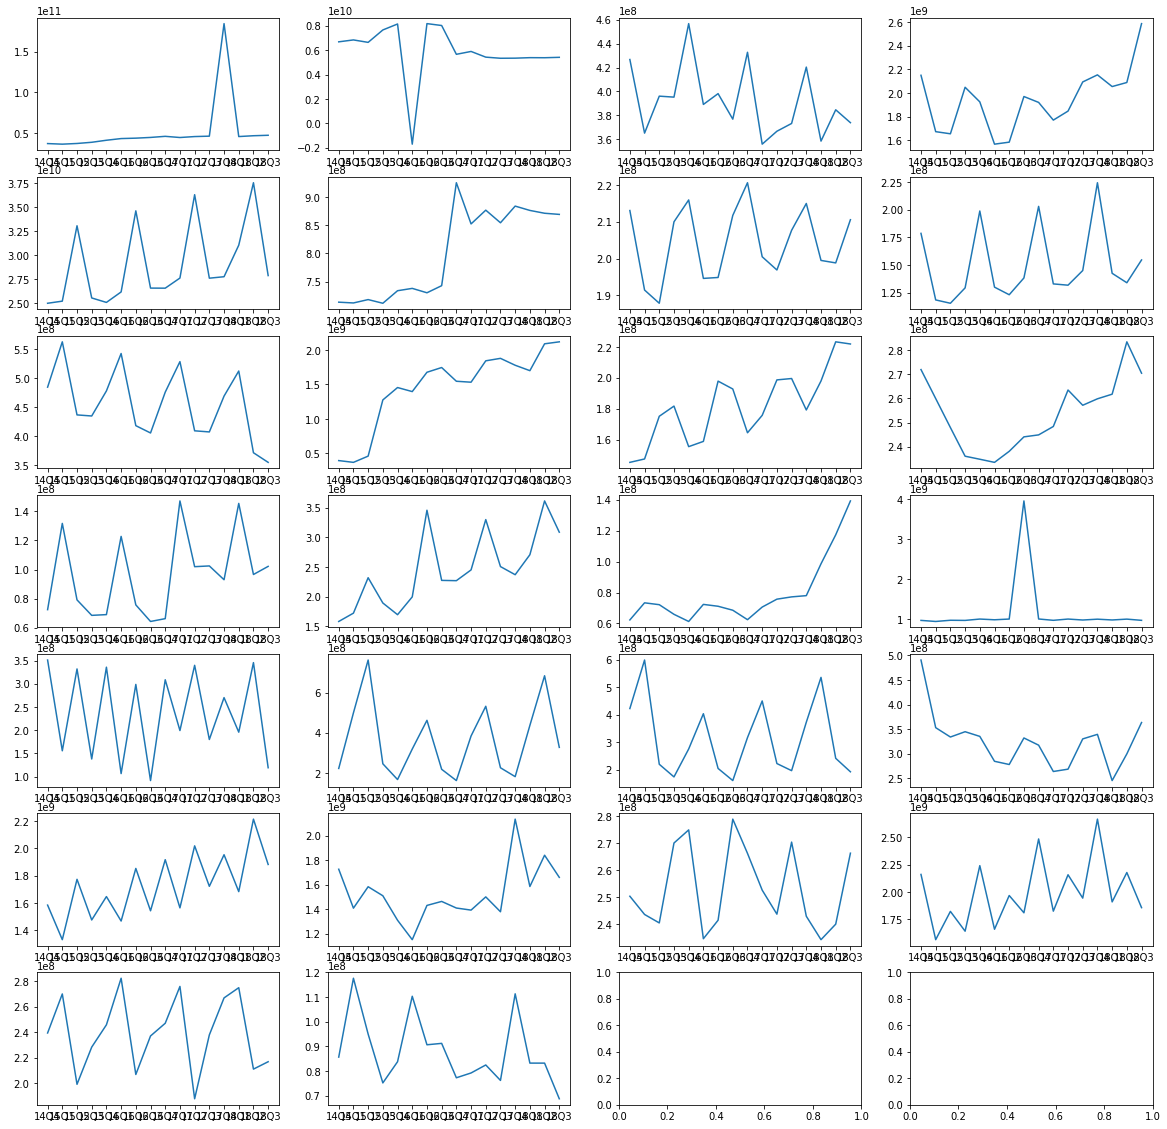

In [284]:
fig, axes = plt.subplots(7,4,figsize=(20,20))

k = 0
for i in range(7):
    for j in range(4):
        axes[i,j].plot(output_y.loc[trainstock[k]])
        k += 1

In [285]:
output_y

,14Q4,15Q1,15Q2,15Q3,15Q4,16Q1,16Q2,16Q3,16Q4,17Q1,17Q2,17Q3,17Q4,18Q1,18Q2,18Q3
CVSHealth,37055000000,36332000000,37169000000,38644000000,41146000000,43215000000,43725000000,44615000000,45971000000,44514000000,45685000000,46181000000,184765000000,45693000000,46708000000,47269000000
RiteAid,6692333000,6847929000,6647561000,7664776000,8154184000,-1696284000,8184181000,8029806000,5669111000,5903386000,5436523000,5345011000,5353170000,5394264000,5388490000,5421362000
Conn's,426748000,365076000,396050000,395233000,456819000,389113000,398157000,376773000,432805000,355826000,366647000,373172000,420386000,358387000,384620000,373824000
Casey's,2150211000,1671961000,1653858000,2048592000,1924600000,1565940000,1582954000,1970079000,1920055000,1769993000,1846460000,2093739000,2153745000,2054603000,2089037000,2588432000
Kroger,24987000000,25207000000,33051000000,25539000000,25075000000,26165000000,34604000000,26565000000,26557000000,27611000000,36285000000,27597000000,27749000000,31031000000,37530000000,27869000000
WeisMarkets,713789000,712426000,718380000,711879000,734063000,738204000,730433000,742986000,925098000,852229000,876569000,854261000,883748000,876106000,871100000,869076000
HavertyFurniture,213073000,191403000,187801000,209992000,215959000,194576000,194828000,211744000,220651000,200472000,196871000,207685000,214997000,199474000,198800000,210571000
Kirkland's,178683000,118310000,115289000,129238000,198970000,129911000,123017000,138240000,203160000,132841000,131683000,144979000,224614000,142454000,133899000,154571000
Pier1Imports,484501000,562375000,436866000,434992000,478047000,542325000,418370000,405823000,475901000,528352000,409525000,407607000,469161000,512229000,371864000,355336000
BuildersFirstSource,396737000,370986000,461521000,1276063000,1455855000,1397114000,1677300000,1745958000,1546912000,1533064000,1843297000,1878909000,1778939000,1700436000,2089888000,2118467000


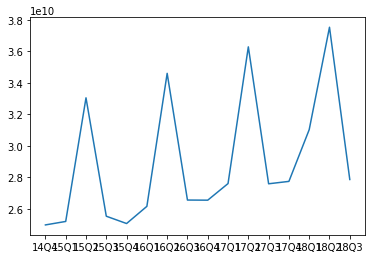

In [286]:
plt.plot(output_y.loc["Kroger"])

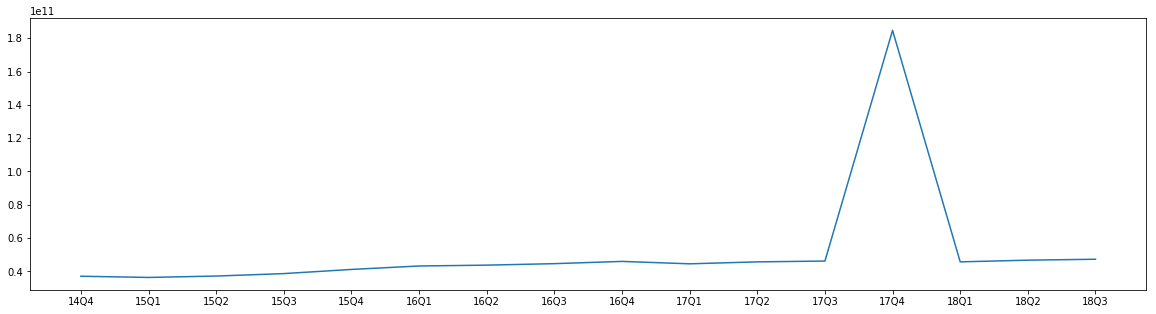

In [287]:
plt.figure(figsize=(20,5))
plt.plot(output_y.loc['CVSHealth'])

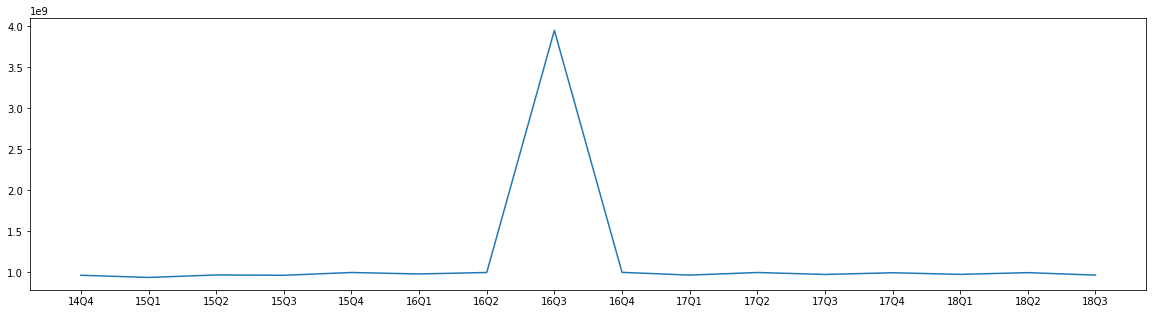

In [288]:
plt.figure(figsize=(20,5))
plt.plot(output_y.loc['SallyBeauty'])

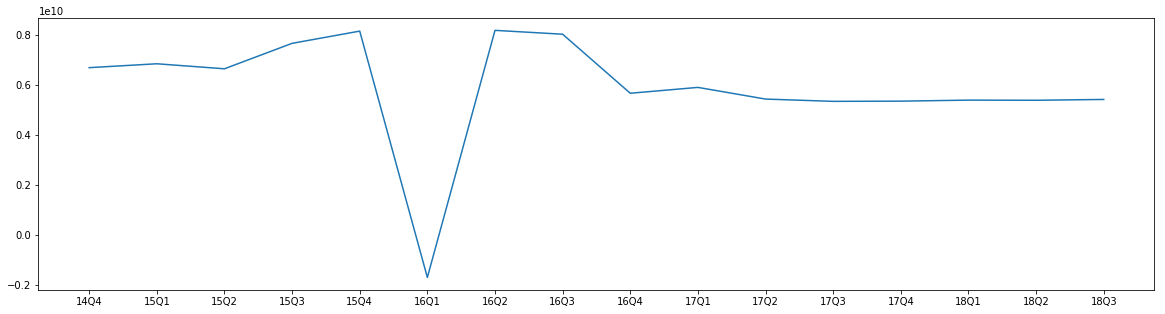

In [289]:
plt.figure(figsize=(20,5))
plt.plot(output_y.loc['RiteAid'])

In [290]:
# Manually correct two data points that appear to be incorrect
print(output_y.loc['CVSHealth'])
print(output_y.loc['SallyBeauty'])
print(output_y.loc['RiteAid'])

output_y.loc['CVSHealth']['17Q4'] = 48385000000
output_y.loc['SallyBeauty']['16Q3'] = 998200000
output_y.loc['RiteAid']['16Q1'] = 8184181000

print(output_y.loc['CVSHealth']['17Q4'])
print(output_y.loc['SallyBeauty']['16Q3'])
print(output_y.loc['RiteAid']['16Q1'])

14Q4     37055000000
15Q1     36332000000
15Q2     37169000000
15Q3     38644000000
15Q4     41146000000
16Q1     43215000000
16Q2     43725000000
16Q3     44615000000
16Q4     45971000000
17Q1     44514000000
17Q2     45685000000
17Q3     46181000000
17Q4    184765000000
18Q1     45693000000
18Q2     46708000000
18Q3     47269000000
Name: CVSHealth, dtype: int64
14Q4     964468000
15Q1     937755000
15Q2     967890000
15Q3     964231000
15Q4     998032000
16Q1     980067000
16Q2     998161000
16Q3    3952618000
16Q4     999609000
17Q1     966470000
17Q2     998043000
17Q3     974195000
17Q4     994964000
18Q1     975321000
18Q2     996283000
18Q3     965997000
Name: SallyBeauty, dtype: int64
14Q4    6692333000
15Q1    6847929000
15Q2    6647561000
15Q3    7664776000
15Q4    8154184000
16Q1   -1696284000
16Q2    8184181000
16Q3    8029806000
16Q4    5669111000
17Q1    5903386000
17Q2    5436523000
17Q3    5345011000
17Q4    5353170000
18Q1    5394264000
18Q2    5388490000
18Q3    54213

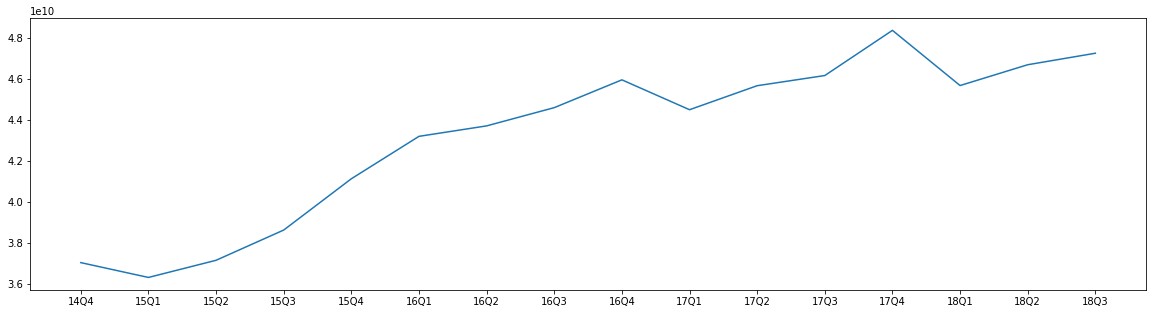

In [291]:
plt.figure(figsize=(20,5))
plt.plot(output_y.loc['CVSHealth'])

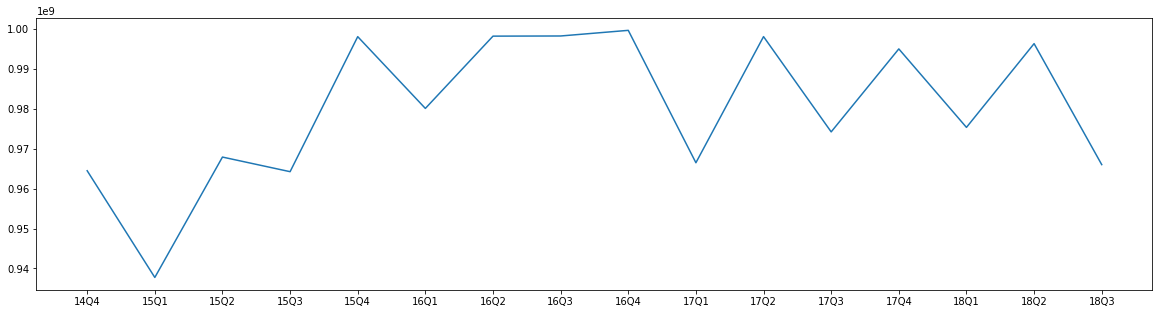

In [292]:
plt.figure(figsize=(20,5))
plt.plot(output_y.loc['SallyBeauty'])

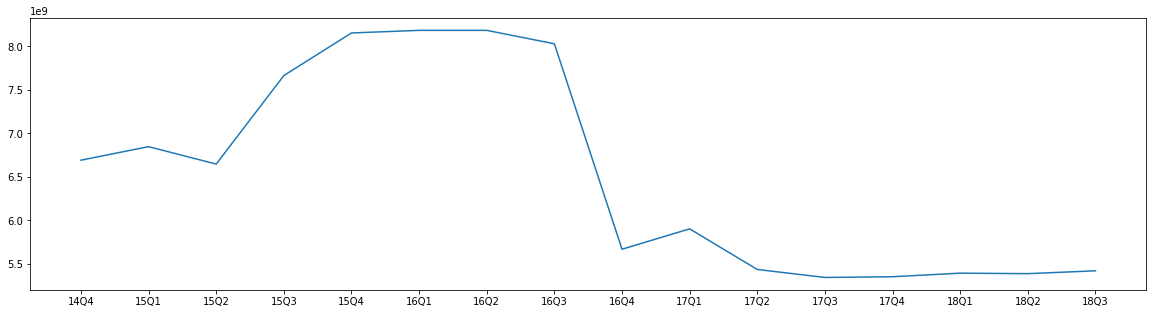

In [293]:
plt.figure(figsize=(20,5))
plt.plot(output_y.loc['RiteAid'])

In [294]:
# compute YoY quarterly revenue change
rev_df = output_y.copy(deep=True)

for i in range(4,16):
    rev_df[qtrs[i]] = output_y[qtrs[i]].sub(output_y[qtrs[i-4]], axis = 0)

rev_df = rev_df.drop(columns = ['14Q4','15Q1','15Q2','15Q3'])
rev_df

,15Q4,16Q1,16Q2,16Q3,16Q4,17Q1,17Q2,17Q3,17Q4,18Q1,18Q2,18Q3
CVSHealth,4091000000,6883000000,6556000000,5971000000,4825000000,1299000000,1960000000,1566000000,2414000000,1179000000,1023000000,1088000000
RiteAid,1461851000,1336252000,1536620000,365030000,-2485073000,-2280795000,-2747658000,-2684795000,-315941000,-509122000,-48033000,76351000
Conn's,30071000,24037000,2107000,-18460000,-24014000,-33287000,-31510000,-3601000,-12419000,2561000,17973000,652000
Casey's,-225611000,-106021000,-70904000,-78513000,-4545000,204053000,263506000,123660000,233690000,284610000,242577000,494693000
Kroger,88000000,958000000,1553000000,1026000000,1482000000,1446000000,1681000000,1032000000,1192000000,3420000000,1245000000,272000000
WeisMarkets,20274000,25778000,12053000,31107000,191035000,114025000,146136000,111275000,-41350000,23877000,-5469000,14815000
HavertyFurniture,2886000,3173000,7027000,1752000,4692000,5896000,2043000,-4059000,-5654000,-998000,1929000,2886000
Kirkland's,20287000,11601000,7728000,9002000,4190000,2930000,8666000,6739000,21454000,9613000,2216000,9592000
Pier1Imports,-6454000,-20050000,-18496000,-29169000,-2146000,-13973000,-8845000,1784000,-6740000,-16123000,-37661000,-52271000
BuildersFirstSource,1059118000,1026128000,1215779000,469895000,91057000,135950000,165997000,132951000,232027000,167372000,246591000,239558000


IndexError: list index out of range

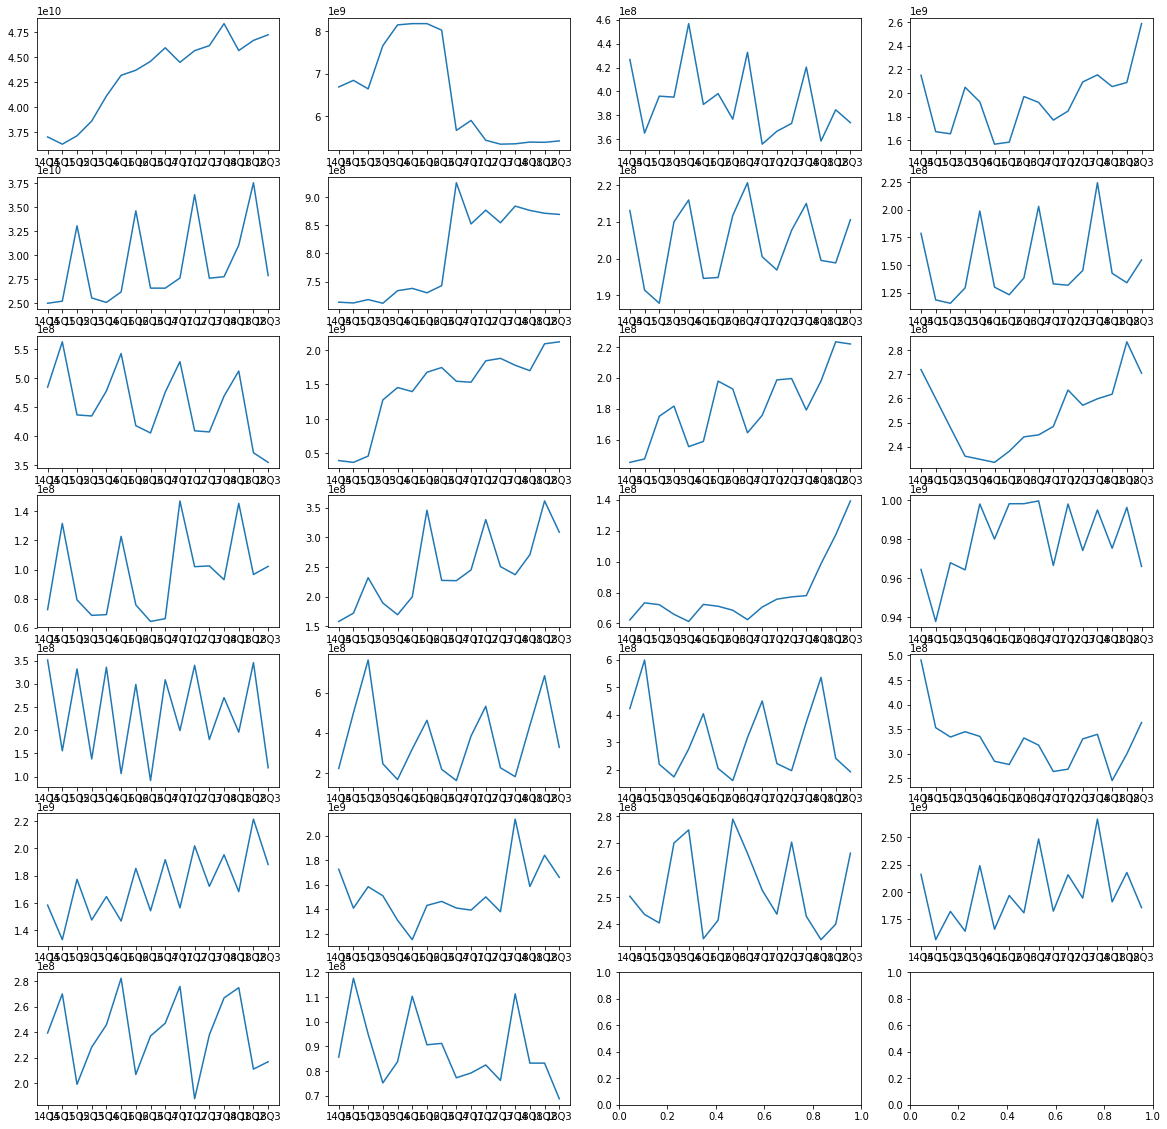

In [295]:
fig, axes = plt.subplots(7,4,figsize=(20,20))

k = 0
for i in range(7):
    for j in range(4):
        axes[i,j].plot(output_y.loc[trainstock[k]])
        k += 1

In [298]:
qtrs = ['15Q4','16Q1','16Q2','16Q3','16Q4','17Q1','17Q2','17Q3','17Q4','18Q1','18Q2','18Q3']
Outputy = defaultdict(dict)
for i in trainstock:
    Outputy[i]['period'] = qtrs
    Outputy[i]['revenue'] = list(rev_df.loc[stock])
for i in trainstock:
    for j in range(len(qtrs)):
        if Outputy[i]['revenue'][j] <= 0:
            Outputy[i]['revenue'][j] = 0
        else:
            Outputy[i]['revenue'][j] = 1

In [307]:
print(Outputy['CVSHealth'])

{'period': ['15Q4', '16Q1', '16Q2', '16Q3', '16Q4', '17Q1', '17Q2', '17Q3', '17Q4', '18Q1', '18Q2', '18Q3'], 'revenue': [0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0]}


In [300]:
with open('Outputy.txt', 'w') as f:
    print(Outputy, file=f)

In [301]:
train_x_init = []
train_n_init = []
train_y_init = []
dev_x_init = []
dev_n_init = []
dev_y_init = []
test_x_init = []
test_n_init = []
test_y_init = []


In [308]:
Outputy['CVSHealth']['revenue'][0]

0

In [309]:
trainquarter=['15Q4','16Q1','16Q2','16Q3','16Q4','17Q1','17Q2','17Q3','17Q4','18Q1']

for i in trainstock:
    for j in range(len(trainquarter)):
        try:
                train_x_init.append(InputX [i][trainquarter[j]])
                train_n_init.append(InputN [i][trainquarter[j]])
                length=len(InputN [i][trainquarter[j]])           
                train_y_init.append([Outputy [i]['revenue'][j]]*length)
      
        except:
            pass



In [310]:
teststock =['CVSHealth', 'RiteAid', "Conn's", "Casey's", 'Kroger','WeisMarkets', 'HavertyFurniture', "Kirkland's", 'Pier1Imports', 'BuildersFirstSource', 'HuttigBuildingProducts', 'LumberLiquidators', 'TransWorldEntertainment', 'MarineMax', 'Medifast', 'SallyBeauty',"Sotheby's", 'StarGasPartners', 'SuburbanPropanePartners', 'TitanMachinery', 'TractorSupply', 'TravelCentersofAmerica', 'Big5SportingGoods', "Dick'sSportingGoods", 'HibbettSports', 'Build-A-BearWorkshop']
# teststock =["Conn's"]
testquarter=['18Q2','18Q3']

for i in teststock:
    for j in range(len(testquarter)):
        try:
            if testquarter[j]=='18Q3':
                test_x_init.append(InputX [i][testquarter[j]])
                test_n_init.append(InputN [i][testquarter[j]])
                length=len(InputN [i][testquarter[j]])
                test_y_init.append([Outputy [i]['revenue'][j]]*length)   
            
            elif testquarter[j]=='18Q2':
                dev_x_init.append(InputX [i][testquarter[j]])
                dev_n_init.append(InputN [i][testquarter[j]])
                length=len(InputN [i][testquarter[j]])
                dev_y_init.append([Outputy [i]['revenue'][j]]*length)     
               
      
        except:
            pass

In [311]:

train_x_init2 = []
train_n_init2 = []
train_y_init2 = []
dev_x_init2 = []
dev_n_init2 = []
dev_y_init2 = []
test_x_init2 = []
test_n_init2 = []
test_y_init2 = []

for i in range(len(train_x_init)):
    for j in range(len(train_x_init[i])):
        train_x_init2.append(train_x_init[i][j])
        train_n_init2.append(train_n_init[i][j])
        train_y_init2.append(train_y_init[i][j])
        
for i in range(len(dev_x_init)):
    for j in range(len(dev_x_init[i])):
        dev_x_init2.append(dev_x_init[i][j])
        dev_n_init2.append(dev_n_init[i][j])
        dev_y_init2.append(dev_y_init[i][j])
        
for i in range(len(test_x_init)):
    for j in range(len(test_x_init[i])):
        test_x_init2.append(test_x_init[i][j])
        test_n_init2.append(test_n_init[i][j])
        test_y_init2.append(test_y_init[i][j])



# NEURAL BAG OF WORDS MODEL #

In [312]:
for i in range(10):

    print(train_x_init2[i])
    print(test_x_init2[i])
    print(dev_x_init2[i])


[1902, 4889, 5406, 403, 1295, 3528, 3482, 4465, 2, 1295, 2, 2, 1299, 2, 2, 2053, 2, 2, 3294, 2, 2, 3349, 2, 2, 3419, 2, 2, 3483, 2, 2, 3546, 2, 2, 4186, 2, 2, 4465, 2, 2, 5406, 2, 2, 5442, 2386, 2, 64, 1854, 353, 5678]
[1902, 4889, 5406, 403, 1295, 3528, 3482, 4465, 2, 1295, 2, 2, 1299, 2, 2, 2053, 2, 2, 3294, 2, 2, 3349, 2, 2, 3419, 2, 2, 3483, 2, 2, 3546, 2, 2, 4186, 2, 2, 4465, 2, 2, 5406, 2, 2, 5442, 2386, 2, 64, 1854, 353, 5678]
[161, 5592, 3437, 4581, 3615, 3455, 5015, 3613, 5100, 654, 2250, 1478, 5673, 4936, 1939, 5100, 4542, 5006, 3614, 2, 1299, 2, 1301, 5669, 949, 5548, 417]
[161, 5592, 3437, 4581, 3615, 3455, 5015, 3613, 5100, 654, 2250, 1478, 5673, 4936, 1939, 5100, 4542, 5006, 3614, 2, 1299, 2, 1301, 5669, 949, 5548, 417]
[1478, 5673, 4936, 3188, 5177, 802, 2, 1741, 5394, 403, 997, 3098, 3445, 3437, 2, 1299, 2, 503, 2, 804, 3455, 1349, 162, 483, 2245, 1448, 5006, 2017, 3437, 2, 2251, 5534, 3515, 2548, 2865, 2868, 3228, 2, 2386, 2, 64, 803, 2]
[4659, 5006, 2, 309, 2, 1299, 1

In [313]:
def pad_np_array2(example_ids, max_len=50, pad_id=0):

    arr = np.full([len(example_ids), max_len], pad_id, dtype=np.int32)
    ns = np.zeros([len(example_ids)], dtype=np.int32)
    for i, ids in enumerate(example_ids):
        cpy_len = min(len(ids), max_len)
        arr[i,:cpy_len] = ids[:cpy_len]
        ns[i] = cpy_len
    return arr ##I HAD TO REMOVE NS TO MAKE IT WORK< PLEASE TAKE A LOOK IF IT HAS ANY IMPACT

In [314]:
train_x = pad_np_array2(train_x_init2, max_len = 50, pad_id=0)
train_n = np.array(train_n_init2)
train_y = np.array(train_y_init2)

test_x = pad_np_array2(test_x_init2, max_len = 50, pad_id=0)
test_n = np.array(test_n_init2)
test_y = np.array(test_y_init2)

dev_x = pad_np_array2(dev_x_init2, max_len = 50, pad_id=0)
dev_n = np.array(dev_n_init2)
dev_y = np.array(dev_y_init2)

In [315]:
print(len(train_x))


print(train_x)

print(type(train_x))
print(train_x.shape)


5153581
[[1902 4889 5406 ...  353 5678    0]
 [ 161 5592 3437 ...    0    0    0]
 [1295 2249    2 ...    2   62 2258]
 ...
 [1417 2659 2526 ...    0    0    0]
 [   2  833   27 ...    0    0    0]
 [   2  833   27 ...    0    0    0]]
<class 'numpy.ndarray'>
(5153581, 50)


In [316]:
reload(models)

x, ns, y = train_x, train_n, train_y
batch_size = 125

# Specify model hyperparameters as used by model_fn
model_params = dict(V=vocab.size, embed_dim=50, hidden_dims=[25], num_classes=2,
                    encoder_type='bow',
                    lr=0.1, optimizer='adagrad', beta=0.01)
model_fn = models.classifier_model_fn

total_batches = 0
total_examples = 0
total_loss = 0
loss_ema = np.log(2)  # track exponential-moving-average of loss
ema_decay = np.exp(-1/10)  # decay parameter for moving average = np.exp(-1/history_length)
with tf.Graph().as_default(), tf.Session() as sess:
    ##
    # Construct the graph here. No session.run calls - just wiring up Tensors.
    ##
    # Add placeholders so we can feed in data.
    x_ph_  = tf.placeholder(tf.int32, shape=[None, x.shape[1]])  # [batch_size, max_len]
    ns_ph_ = tf.placeholder(tf.int32, shape=[None])              # [batch_size]
    y_ph_  = tf.placeholder(tf.int32, shape=[None])              # [batch_size]
    
    # Construct the graph using model_fn
    features = {"ids": x_ph_, "ns": ns_ph_}  # note that values are Tensors
    estimator_spec = model_fn(features, labels=y_ph_, mode=tf.estimator.ModeKeys.TRAIN,
                              params=model_params)
    loss_     = estimator_spec.loss
    train_op_ = estimator_spec.train_op
    
    ##
    # Done constructing the graph, now we can make session.run calls.
    ##
    sess.run(tf.global_variables_initializer())
    
    # Run a single epoch
    t0 = time.time()
    for (bx, bns, by) in utils.multi_batch_generator(batch_size, x, ns, y):
        # feed NumPy arrays into the placeholder Tensors
        feed_dict = {x_ph_: bx, ns_ph_: bns, y_ph_: by}
        batch_loss, _ = sess.run([loss_, train_op_], feed_dict=feed_dict)
        
        # Compute some statistics
        total_batches += 1
        total_examples += len(bx)
        total_loss += batch_loss * len(bx)  # re-scale, since batch loss is mean
        # Compute moving average to smooth out noisy per-batch loss
        loss_ema = ema_decay * loss_ema + (1 - ema_decay) * batch_loss
        
        if (total_batches % 125 == 0):
            print("{:5,} examples, moving-average loss {:.2f}".format(total_examples, 
                                                                      loss_ema))    
    print("Completed one epoch in {:s}".format(utils.pretty_timedelta(since=t0)))

15,625 examples, moving-average loss 1.18
31,250 examples, moving-average loss 0.26
46,875 examples, moving-average loss 0.10
62,500 examples, moving-average loss 0.08
78,125 examples, moving-average loss 0.07
93,750 examples, moving-average loss 0.11
109,375 examples, moving-average loss 0.11
125,000 examples, moving-average loss 0.06
140,625 examples, moving-average loss 0.06
156,250 examples, moving-average loss 0.05
171,875 examples, moving-average loss 0.31
187,500 examples, moving-average loss 0.09
203,125 examples, moving-average loss 0.11
218,750 examples, moving-average loss 0.07
234,375 examples, moving-average loss 0.06
250,000 examples, moving-average loss 0.06
265,625 examples, moving-average loss 0.10
281,250 examples, moving-average loss 0.07
296,875 examples, moving-average loss 0.06
312,500 examples, moving-average loss 0.06
328,125 examples, moving-average loss 0.05
343,750 examples, moving-average loss 0.05
359,375 examples, moving-average loss 0.10
375,000 examples,

2,906,250 examples, moving-average loss 0.06
2,921,875 examples, moving-average loss 0.05
2,937,500 examples, moving-average loss 0.09
2,953,125 examples, moving-average loss 0.06
2,968,750 examples, moving-average loss 0.05
2,984,375 examples, moving-average loss 0.05
3,000,000 examples, moving-average loss 0.05
3,015,625 examples, moving-average loss 0.05
3,031,250 examples, moving-average loss 0.10
3,046,875 examples, moving-average loss 0.07
3,062,500 examples, moving-average loss 0.14
3,078,125 examples, moving-average loss 0.07
3,093,750 examples, moving-average loss 0.06
3,109,375 examples, moving-average loss 0.06
3,125,000 examples, moving-average loss 0.06
3,140,625 examples, moving-average loss 0.19
3,156,250 examples, moving-average loss 0.09
3,171,875 examples, moving-average loss 0.07
3,187,500 examples, moving-average loss 0.06
3,203,125 examples, moving-average loss 0.06
3,218,750 examples, moving-average loss 0.06
3,234,375 examples, moving-average loss 0.06
3,250,000 

In [317]:
import models; reload(models)

# Specify model hyperparameters as used by model_fn
model_params = dict(V=vocab.size, embed_dim=50, hidden_dims=[25], num_classes=2,
                    encoder_type='bow',
                    lr=0.1, optimizer='adagrad', beta=0.01)

checkpoint_dir = "/tmp/tf_bow_sst_" + datetime.datetime.now().strftime("%Y%m%d-%H%M")
if os.path.isdir(checkpoint_dir):
    shutil.rmtree(checkpoint_dir)
# Write vocabulary to file, so TensorBoard can label embeddings.
# creates checkpoint_dir/projector_config.pbtxt and checkpoint_dir/metadata.tsv
vocab.write_projector_config(checkpoint_dir, "Encoder/Embedding_Layer/W_embed")

model = tf.estimator.Estimator(model_fn=models.classifier_model_fn, 
                               params=model_params,
                               model_dir=checkpoint_dir)
print("")
print("To view training (once it starts), run:\n")
print("    tensorboard --logdir='{:s}' --port 6006".format(checkpoint_dir))
print("\nThen in your browser, open: http://localhost:6006")

Vocabulary (5,681 words) written to '/tmp/tf_bow_sst_20181206-0522/metadata.tsv'
Projector config written to /tmp/tf_bow_sst_20181206-0522/projector_config.pbtxt
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tf_bow_sst_20181206-0522', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f9916d3a6a0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}

To view training (once it starts), run:

    tensorboard --logdir='/tmp/tf_bow_sst_20181206-0522' --port 6006

Then in your browser, open: http:

In [318]:
# Training params, just used in this cell for the input_fn-s
train_params = dict(batch_size=125, total_epochs=10, eval_every=2)
assert(train_params['total_epochs'] % train_params['eval_every'] == 0)

# Construct and train the model, saving checkpoints to the directory above.
# Input function for training set batches
# Do 'eval_every' epochs at once, followed by evaluating on the dev set.
# NOTE: use patch_numpy_io.numpy_input_fn instead of tf.estimator.inputs.numpy_input_fn
train_input_fn = patched_numpy_io.numpy_input_fn(
                    x={"ids": train_x, "ns": train_n}, y=train_y,
                    batch_size=train_params['batch_size'], 
                    num_epochs=train_params['eval_every'], shuffle=True, seed=42
                 )

# Input function for dev set batches. As above, but:
# - Don't randomize order
# - Iterate exactly once (one epoch)
dev_input_fn = tf.estimator.inputs.numpy_input_fn(
                    x={"ids": dev_x, "ns": dev_n}, y=dev_y,
                    batch_size=125, num_epochs=1, shuffle=False
                )

for _ in range(train_params['total_epochs'] // train_params['eval_every']):
    # Train for a few epochs, then evaluate on dev
    model.train(input_fn=train_input_fn)
    eval_metrics = model.evaluate(input_fn=dev_input_fn, name="dev")

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into /tmp/tf_bow_sst_20181206-0522/model.ckpt.
INFO:tensorflow:loss = 1.1836784, step = 1
INFO:tensorflow:global_step/sec: 127.053
INFO:tensorflow:loss = 0.29020494, step = 101 (0.788 sec)
INFO:tensorflow:global_step/sec: 151.799
INFO:tensorflow:loss = 0.1794495, step = 201 (0.660 sec)
INFO:tensorflow:global_step/sec: 143.38
INFO:tensorflow:loss = 0.15671436, step = 301 (0.697 sec)
INFO:tensorflow:global_step/sec: 146.962
INFO:tensorflow:loss = 0.11009246, step = 401 (0.681 sec)
INFO:tensorflow:global_step/sec: 146.916
INFO:tensorflow:loss = 0.08715403, step = 501 (0.680 sec)
INFO:tensorflow:global_step/sec: 149.908
INFO:tensorflow:loss = 0.072471984, step = 601 (0.668 sec)
INFO:tensorflow:global_step/sec: 143.90

INFO:tensorflow:loss = 0.085510716, step = 7901 (0.649 sec)
INFO:tensorflow:global_step/sec: 149.248
INFO:tensorflow:loss = 0.07455178, step = 8001 (0.670 sec)
INFO:tensorflow:global_step/sec: 153.324
INFO:tensorflow:loss = 0.06971771, step = 8101 (0.652 sec)
INFO:tensorflow:global_step/sec: 157.331
INFO:tensorflow:loss = 0.10659066, step = 8201 (0.636 sec)
INFO:tensorflow:global_step/sec: 155.499
INFO:tensorflow:loss = 0.06710648, step = 8301 (0.642 sec)
INFO:tensorflow:global_step/sec: 156.48
INFO:tensorflow:loss = 0.06317878, step = 8401 (0.640 sec)
INFO:tensorflow:global_step/sec: 152.669
INFO:tensorflow:loss = 0.059872888, step = 8501 (0.655 sec)
INFO:tensorflow:global_step/sec: 152.784
INFO:tensorflow:loss = 0.056895163, step = 8601 (0.655 sec)
INFO:tensorflow:global_step/sec: 155.745
INFO:tensorflow:loss = 0.054539457, step = 8701 (0.641 sec)
INFO:tensorflow:global_step/sec: 153.09
INFO:tensorflow:loss = 0.78742826, step = 8801 (0.653 sec)
INFO:tensorflow:global_step/sec: 154.68

INFO:tensorflow:global_step/sec: 146.451
INFO:tensorflow:loss = 0.17861503, step = 16101 (0.682 sec)
INFO:tensorflow:global_step/sec: 152.651
INFO:tensorflow:loss = 0.07460595, step = 16201 (0.655 sec)
INFO:tensorflow:global_step/sec: 150.334
INFO:tensorflow:loss = 0.052800436, step = 16301 (0.665 sec)
INFO:tensorflow:global_step/sec: 147.666
INFO:tensorflow:loss = 0.051811714, step = 16401 (0.677 sec)
INFO:tensorflow:global_step/sec: 148.039
INFO:tensorflow:loss = 0.051184326, step = 16501 (0.676 sec)
INFO:tensorflow:global_step/sec: 150.29
INFO:tensorflow:loss = 0.04878349, step = 16601 (0.665 sec)
INFO:tensorflow:global_step/sec: 150.751
INFO:tensorflow:loss = 0.34155688, step = 16701 (0.663 sec)
INFO:tensorflow:global_step/sec: 152.59
INFO:tensorflow:loss = 0.08817368, step = 16801 (0.656 sec)
INFO:tensorflow:global_step/sec: 145.784
INFO:tensorflow:loss = 0.06951405, step = 16901 (0.686 sec)
INFO:tensorflow:global_step/sec: 151.025
INFO:tensorflow:loss = 0.11648205, step = 17001 (

INFO:tensorflow:global_step/sec: 169.327
INFO:tensorflow:loss = 0.05342305, step = 24201 (0.591 sec)
INFO:tensorflow:global_step/sec: 167.42
INFO:tensorflow:loss = 0.051307756, step = 24301 (0.596 sec)
INFO:tensorflow:global_step/sec: 168.879
INFO:tensorflow:loss = 0.050688498, step = 24401 (0.595 sec)
INFO:tensorflow:global_step/sec: 170.387
INFO:tensorflow:loss = 0.04898585, step = 24501 (0.585 sec)
INFO:tensorflow:global_step/sec: 167.402
INFO:tensorflow:loss = 0.14773853, step = 24601 (0.597 sec)
INFO:tensorflow:global_step/sec: 162.695
INFO:tensorflow:loss = 0.09481145, step = 24701 (0.615 sec)
INFO:tensorflow:global_step/sec: 164.354
INFO:tensorflow:loss = 0.081714615, step = 24801 (0.610 sec)
INFO:tensorflow:global_step/sec: 163.035
INFO:tensorflow:loss = 0.07887507, step = 24901 (0.612 sec)
INFO:tensorflow:global_step/sec: 170.3
INFO:tensorflow:loss = 0.09571257, step = 25001 (0.587 sec)
INFO:tensorflow:global_step/sec: 172.653
INFO:tensorflow:loss = 0.08249311, step = 25101 (0

INFO:tensorflow:global_step/sec: 169.998
INFO:tensorflow:loss = 0.057038333, step = 32301 (0.588 sec)
INFO:tensorflow:global_step/sec: 171.594
INFO:tensorflow:loss = 0.055391006, step = 32401 (0.583 sec)
INFO:tensorflow:global_step/sec: 170.432
INFO:tensorflow:loss = 0.08926371, step = 32501 (0.587 sec)
INFO:tensorflow:global_step/sec: 170.525
INFO:tensorflow:loss = 0.07524902, step = 32601 (0.586 sec)
INFO:tensorflow:global_step/sec: 168.453
INFO:tensorflow:loss = 0.06272098, step = 32701 (0.594 sec)
INFO:tensorflow:global_step/sec: 170.199
INFO:tensorflow:loss = 0.058453765, step = 32801 (0.588 sec)
INFO:tensorflow:global_step/sec: 164.381
INFO:tensorflow:loss = 0.056620155, step = 32901 (0.612 sec)
INFO:tensorflow:global_step/sec: 166.909
INFO:tensorflow:loss = 0.055364124, step = 33001 (0.596 sec)
INFO:tensorflow:global_step/sec: 159.662
INFO:tensorflow:loss = 0.05407401, step = 33101 (0.626 sec)
INFO:tensorflow:global_step/sec: 136.776
INFO:tensorflow:loss = 0.052809555, step = 33

INFO:tensorflow:global_step/sec: 159.972
INFO:tensorflow:loss = 0.066148296, step = 40401 (0.625 sec)
INFO:tensorflow:global_step/sec: 167.269
INFO:tensorflow:loss = 0.058336236, step = 40501 (0.598 sec)
INFO:tensorflow:global_step/sec: 164.305
INFO:tensorflow:loss = 0.061414678, step = 40601 (0.608 sec)
INFO:tensorflow:global_step/sec: 166.371
INFO:tensorflow:loss = 0.055445872, step = 40701 (0.601 sec)
INFO:tensorflow:global_step/sec: 168.383
INFO:tensorflow:loss = 0.055560984, step = 40801 (0.595 sec)
INFO:tensorflow:global_step/sec: 157.414
INFO:tensorflow:loss = 0.052373935, step = 40901 (0.634 sec)
INFO:tensorflow:global_step/sec: 158.331
INFO:tensorflow:loss = 0.053136878, step = 41001 (0.633 sec)
INFO:tensorflow:global_step/sec: 166.074
INFO:tensorflow:loss = 0.1291011, step = 41101 (0.601 sec)
INFO:tensorflow:global_step/sec: 158.199
INFO:tensorflow:loss = 0.102396004, step = 41201 (0.632 sec)
INFO:tensorflow:global_step/sec: 164.718
INFO:tensorflow:loss = 0.091463, step = 413

INFO:tensorflow:global_step/sec: 166.483
INFO:tensorflow:loss = 0.05386437, step = 48501 (0.600 sec)
INFO:tensorflow:global_step/sec: 170.611
INFO:tensorflow:loss = 0.05427359, step = 48601 (0.587 sec)
INFO:tensorflow:global_step/sec: 171.513
INFO:tensorflow:loss = 0.051516615, step = 48701 (0.583 sec)
INFO:tensorflow:global_step/sec: 163.742
INFO:tensorflow:loss = 0.052488476, step = 48801 (0.611 sec)
INFO:tensorflow:global_step/sec: 162.143
INFO:tensorflow:loss = 0.05136777, step = 48901 (0.616 sec)
INFO:tensorflow:global_step/sec: 165.581
INFO:tensorflow:loss = 0.05091185, step = 49001 (0.604 sec)
INFO:tensorflow:global_step/sec: 165.826
INFO:tensorflow:loss = 0.08788464, step = 49101 (0.603 sec)
INFO:tensorflow:global_step/sec: 169.192
INFO:tensorflow:loss = 0.08453686, step = 49201 (0.591 sec)
INFO:tensorflow:global_step/sec: 160.042
INFO:tensorflow:loss = 0.07838342, step = 49301 (0.628 sec)
INFO:tensorflow:global_step/sec: 158.522
INFO:tensorflow:loss = 0.07692076, step = 49401 

INFO:tensorflow:global_step/sec: 174.29
INFO:tensorflow:loss = 0.074993744, step = 56601 (0.573 sec)
INFO:tensorflow:global_step/sec: 165.988
INFO:tensorflow:loss = 0.10269542, step = 56701 (0.602 sec)
INFO:tensorflow:global_step/sec: 169.426
INFO:tensorflow:loss = 0.06744545, step = 56801 (0.591 sec)
INFO:tensorflow:global_step/sec: 164.902
INFO:tensorflow:loss = 0.057711694, step = 56901 (0.606 sec)
INFO:tensorflow:global_step/sec: 165.202
INFO:tensorflow:loss = 0.06536371, step = 57001 (0.605 sec)
INFO:tensorflow:global_step/sec: 165.711
INFO:tensorflow:loss = 0.056701824, step = 57101 (0.604 sec)
INFO:tensorflow:global_step/sec: 159.662
INFO:tensorflow:loss = 0.09285858, step = 57201 (0.627 sec)
INFO:tensorflow:global_step/sec: 161.412
INFO:tensorflow:loss = 0.10186044, step = 57301 (0.619 sec)
INFO:tensorflow:global_step/sec: 165.338
INFO:tensorflow:loss = 0.07713375, step = 57401 (0.605 sec)
INFO:tensorflow:global_step/sec: 165.237
INFO:tensorflow:loss = 0.055158418, step = 57501

INFO:tensorflow:global_step/sec: 169.115
INFO:tensorflow:loss = 0.056425236, step = 64701 (0.591 sec)
INFO:tensorflow:global_step/sec: 171.894
INFO:tensorflow:loss = 0.0563237, step = 64801 (0.583 sec)
INFO:tensorflow:global_step/sec: 165.955
INFO:tensorflow:loss = 0.094794825, step = 64901 (0.602 sec)
INFO:tensorflow:global_step/sec: 165.585
INFO:tensorflow:loss = 0.08688414, step = 65001 (0.604 sec)
INFO:tensorflow:global_step/sec: 163.859
INFO:tensorflow:loss = 0.060400415, step = 65101 (0.610 sec)
INFO:tensorflow:global_step/sec: 166.844
INFO:tensorflow:loss = 0.05873872, step = 65201 (0.599 sec)
INFO:tensorflow:global_step/sec: 168.122
INFO:tensorflow:loss = 0.057084527, step = 65301 (0.595 sec)
INFO:tensorflow:global_step/sec: 166.6
INFO:tensorflow:loss = 0.05587977, step = 65401 (0.600 sec)
INFO:tensorflow:global_step/sec: 173.382
INFO:tensorflow:loss = 0.055056382, step = 65501 (0.582 sec)
INFO:tensorflow:global_step/sec: 167.68
INFO:tensorflow:loss = 0.054174133, step = 65601 

INFO:tensorflow:global_step/sec: 160.567
INFO:tensorflow:loss = 0.056829438, step = 72801 (0.623 sec)
INFO:tensorflow:global_step/sec: 168.298
INFO:tensorflow:loss = 0.1797243, step = 72901 (0.594 sec)
INFO:tensorflow:global_step/sec: 168.584
INFO:tensorflow:loss = 0.085265286, step = 73001 (0.593 sec)
INFO:tensorflow:global_step/sec: 169.17
INFO:tensorflow:loss = 0.09831844, step = 73101 (0.591 sec)
INFO:tensorflow:global_step/sec: 173.227
INFO:tensorflow:loss = 0.06267095, step = 73201 (0.578 sec)
INFO:tensorflow:global_step/sec: 170.493
INFO:tensorflow:loss = 0.0602326, step = 73301 (0.587 sec)
INFO:tensorflow:global_step/sec: 172.211
INFO:tensorflow:loss = 0.059444077, step = 73401 (0.580 sec)
INFO:tensorflow:global_step/sec: 172.25
INFO:tensorflow:loss = 0.057972394, step = 73501 (0.581 sec)
INFO:tensorflow:global_step/sec: 168.053
INFO:tensorflow:loss = 0.056608967, step = 73601 (0.595 sec)
INFO:tensorflow:global_step/sec: 169.549
INFO:tensorflow:loss = 0.10043937, step = 73701 (

INFO:tensorflow:global_step/sec: 169.866
INFO:tensorflow:loss = 0.061453264, step = 80901 (0.589 sec)
INFO:tensorflow:global_step/sec: 163.984
INFO:tensorflow:loss = 0.058927428, step = 81001 (0.610 sec)
INFO:tensorflow:global_step/sec: 164.927
INFO:tensorflow:loss = 0.059196893, step = 81101 (0.606 sec)
INFO:tensorflow:global_step/sec: 167.925
INFO:tensorflow:loss = 0.15477589, step = 81201 (0.596 sec)
INFO:tensorflow:global_step/sec: 170.726
INFO:tensorflow:loss = 0.10502808, step = 81301 (0.585 sec)
INFO:tensorflow:global_step/sec: 167.804
INFO:tensorflow:loss = 0.10831349, step = 81401 (0.596 sec)
INFO:tensorflow:global_step/sec: 165.478
INFO:tensorflow:loss = 0.070364654, step = 81501 (0.605 sec)
INFO:tensorflow:global_step/sec: 170.221
INFO:tensorflow:loss = 0.07198624, step = 81601 (0.587 sec)
INFO:tensorflow:global_step/sec: 167.821
INFO:tensorflow:loss = 0.06081714, step = 81701 (0.596 sec)
INFO:tensorflow:global_step/sec: 172.667
INFO:tensorflow:loss = 0.06044529, step = 8180

INFO:tensorflow:loss = 0.06006603, step = 87759 (0.657 sec)
INFO:tensorflow:global_step/sec: 149.654
INFO:tensorflow:loss = 0.058918223, step = 87859 (0.668 sec)
INFO:tensorflow:global_step/sec: 152.847
INFO:tensorflow:loss = 0.057802737, step = 87959 (0.654 sec)
INFO:tensorflow:global_step/sec: 155.789
INFO:tensorflow:loss = 0.056329418, step = 88059 (0.642 sec)
INFO:tensorflow:global_step/sec: 159.539
INFO:tensorflow:loss = 0.055713188, step = 88159 (0.627 sec)
INFO:tensorflow:global_step/sec: 155.022
INFO:tensorflow:loss = 0.45942754, step = 88259 (0.645 sec)
INFO:tensorflow:global_step/sec: 155.906
INFO:tensorflow:loss = 0.09730901, step = 88359 (0.641 sec)
INFO:tensorflow:global_step/sec: 157.883
INFO:tensorflow:loss = 0.09060052, step = 88459 (0.633 sec)
INFO:tensorflow:global_step/sec: 158.255
INFO:tensorflow:loss = 0.08635393, step = 88559 (0.632 sec)
INFO:tensorflow:global_step/sec: 151.214
INFO:tensorflow:loss = 0.08384754, step = 88659 (0.662 sec)
INFO:tensorflow:global_step

INFO:tensorflow:loss = 0.09612806, step = 95859 (0.642 sec)
INFO:tensorflow:global_step/sec: 160.916
INFO:tensorflow:loss = 0.19139357, step = 95959 (0.621 sec)
INFO:tensorflow:global_step/sec: 161.126
INFO:tensorflow:loss = 0.07299139, step = 96059 (0.620 sec)
INFO:tensorflow:global_step/sec: 165.641
INFO:tensorflow:loss = 0.09559971, step = 96159 (0.604 sec)
INFO:tensorflow:global_step/sec: 161.401
INFO:tensorflow:loss = 0.060409, step = 96259 (0.619 sec)
INFO:tensorflow:global_step/sec: 158.459
INFO:tensorflow:loss = 0.05904455, step = 96359 (0.633 sec)
INFO:tensorflow:global_step/sec: 168.123
INFO:tensorflow:loss = 0.056869965, step = 96459 (0.594 sec)
INFO:tensorflow:global_step/sec: 166.914
INFO:tensorflow:loss = 0.056678284, step = 96559 (0.599 sec)
INFO:tensorflow:global_step/sec: 166.726
INFO:tensorflow:loss = 0.055085912, step = 96659 (0.600 sec)
INFO:tensorflow:global_step/sec: 166.602
INFO:tensorflow:loss = 0.079106614, step = 96759 (0.600 sec)
INFO:tensorflow:global_step/s

INFO:tensorflow:loss = 0.054143, step = 103959 (0.617 sec)
INFO:tensorflow:global_step/sec: 169.879
INFO:tensorflow:loss = 0.05285698, step = 104059 (0.589 sec)
INFO:tensorflow:global_step/sec: 169.238
INFO:tensorflow:loss = 0.052383367, step = 104159 (0.591 sec)
INFO:tensorflow:global_step/sec: 169.543
INFO:tensorflow:loss = 0.08094223, step = 104259 (0.590 sec)
INFO:tensorflow:global_step/sec: 166.49
INFO:tensorflow:loss = 0.07185911, step = 104359 (0.601 sec)
INFO:tensorflow:global_step/sec: 163.312
INFO:tensorflow:loss = 0.05625279, step = 104459 (0.613 sec)
INFO:tensorflow:global_step/sec: 166.219
INFO:tensorflow:loss = 0.053450584, step = 104559 (0.602 sec)
INFO:tensorflow:global_step/sec: 161.662
INFO:tensorflow:loss = 0.052392535, step = 104659 (0.619 sec)
INFO:tensorflow:global_step/sec: 155.321
INFO:tensorflow:loss = 0.051157285, step = 104759 (0.643 sec)
INFO:tensorflow:global_step/sec: 169.808
INFO:tensorflow:loss = 0.050585803, step = 104859 (0.589 sec)
INFO:tensorflow:glo

INFO:tensorflow:global_step/sec: 163.448
INFO:tensorflow:loss = 0.13197058, step = 112059 (0.612 sec)
INFO:tensorflow:global_step/sec: 170.952
INFO:tensorflow:loss = 0.064234704, step = 112159 (0.585 sec)
INFO:tensorflow:global_step/sec: 163.618
INFO:tensorflow:loss = 0.061978243, step = 112259 (0.611 sec)
INFO:tensorflow:global_step/sec: 167.131
INFO:tensorflow:loss = 0.06079281, step = 112359 (0.599 sec)
INFO:tensorflow:global_step/sec: 163.342
INFO:tensorflow:loss = 0.057850167, step = 112459 (0.612 sec)
INFO:tensorflow:global_step/sec: 169.898
INFO:tensorflow:loss = 0.05792103, step = 112559 (0.589 sec)
INFO:tensorflow:global_step/sec: 165.674
INFO:tensorflow:loss = 0.056287352, step = 112659 (0.603 sec)
INFO:tensorflow:global_step/sec: 167.179
INFO:tensorflow:loss = 0.056884572, step = 112759 (0.598 sec)
INFO:tensorflow:global_step/sec: 167.082
INFO:tensorflow:loss = 0.17958792, step = 112859 (0.599 sec)
INFO:tensorflow:global_step/sec: 166.867
INFO:tensorflow:loss = 0.0946648, st

INFO:tensorflow:loss = 0.09605213, step = 120059 (0.610 sec)
INFO:tensorflow:global_step/sec: 160.347
INFO:tensorflow:loss = 0.42801163, step = 120159 (0.623 sec)
INFO:tensorflow:global_step/sec: 167.651
INFO:tensorflow:loss = 0.85503346, step = 120259 (0.597 sec)
INFO:tensorflow:global_step/sec: 168.173
INFO:tensorflow:loss = 0.07073447, step = 120359 (0.595 sec)
INFO:tensorflow:global_step/sec: 173.223
INFO:tensorflow:loss = 0.08017202, step = 120459 (0.577 sec)
INFO:tensorflow:global_step/sec: 170.213
INFO:tensorflow:loss = 0.09732881, step = 120559 (0.588 sec)
INFO:tensorflow:global_step/sec: 170.439
INFO:tensorflow:loss = 0.062762804, step = 120659 (0.587 sec)
INFO:tensorflow:global_step/sec: 160.065
INFO:tensorflow:loss = 0.060808823, step = 120759 (0.625 sec)
INFO:tensorflow:global_step/sec: 166.656
INFO:tensorflow:loss = 0.06029633, step = 120859 (0.600 sec)
INFO:tensorflow:global_step/sec: 172.751
INFO:tensorflow:loss = 0.0953069, step = 120959 (0.579 sec)
INFO:tensorflow:glob

INFO:tensorflow:global_step/sec: 167.646
INFO:tensorflow:loss = 0.061756402, step = 128159 (0.597 sec)
INFO:tensorflow:global_step/sec: 166.365
INFO:tensorflow:loss = 0.060700517, step = 128259 (0.601 sec)
INFO:tensorflow:global_step/sec: 164.722
INFO:tensorflow:loss = 0.060087718, step = 128359 (0.607 sec)
INFO:tensorflow:global_step/sec: 162.975
INFO:tensorflow:loss = 0.059207432, step = 128459 (0.614 sec)
INFO:tensorflow:global_step/sec: 164.461
INFO:tensorflow:loss = 0.093131945, step = 128559 (0.608 sec)
INFO:tensorflow:global_step/sec: 157.467
INFO:tensorflow:loss = 0.08748243, step = 128659 (0.635 sec)
INFO:tensorflow:global_step/sec: 158.461
INFO:tensorflow:loss = 0.063602395, step = 128759 (0.630 sec)
INFO:tensorflow:global_step/sec: 160.272
INFO:tensorflow:loss = 0.06137932, step = 128859 (0.625 sec)
INFO:tensorflow:global_step/sec: 169.337
INFO:tensorflow:loss = 0.06033168, step = 128959 (0.590 sec)
INFO:tensorflow:global_step/sec: 166.816
INFO:tensorflow:loss = 0.0592413, s

INFO:tensorflow:loss = 0.054665197, step = 136159 (0.628 sec)
INFO:tensorflow:global_step/sec: 161.903
INFO:tensorflow:loss = 0.31435537, step = 136259 (0.617 sec)
INFO:tensorflow:global_step/sec: 159.671
INFO:tensorflow:loss = 0.07790821, step = 136359 (0.626 sec)
INFO:tensorflow:global_step/sec: 163.414
INFO:tensorflow:loss = 0.061945453, step = 136459 (0.613 sec)
INFO:tensorflow:global_step/sec: 159.335
INFO:tensorflow:loss = 0.062951505, step = 136559 (0.627 sec)
INFO:tensorflow:global_step/sec: 164.604
INFO:tensorflow:loss = 0.05421726, step = 136659 (0.608 sec)
INFO:tensorflow:global_step/sec: 159.145
INFO:tensorflow:loss = 0.053363435, step = 136759 (0.628 sec)
INFO:tensorflow:global_step/sec: 162.127
INFO:tensorflow:loss = 0.06875254, step = 136859 (0.616 sec)
INFO:tensorflow:global_step/sec: 162.571
INFO:tensorflow:loss = 0.05230843, step = 136959 (0.616 sec)
INFO:tensorflow:global_step/sec: 160.47
INFO:tensorflow:loss = 0.46343905, step = 137059 (0.623 sec)
INFO:tensorflow:gl

INFO:tensorflow:global_step/sec: 163.383
INFO:tensorflow:loss = 0.05846765, step = 144259 (0.612 sec)
INFO:tensorflow:global_step/sec: 159.813
INFO:tensorflow:loss = 0.05776947, step = 144359 (0.626 sec)
INFO:tensorflow:global_step/sec: 163.427
INFO:tensorflow:loss = 0.5592604, step = 144459 (0.612 sec)
INFO:tensorflow:global_step/sec: 166.254
INFO:tensorflow:loss = 0.09744226, step = 144559 (0.602 sec)
INFO:tensorflow:global_step/sec: 165.876
INFO:tensorflow:loss = 0.091825716, step = 144659 (0.603 sec)
INFO:tensorflow:global_step/sec: 167.583
INFO:tensorflow:loss = 0.088901825, step = 144759 (0.596 sec)
INFO:tensorflow:global_step/sec: 166.658
INFO:tensorflow:loss = 0.08697376, step = 144859 (0.600 sec)
INFO:tensorflow:global_step/sec: 163.402
INFO:tensorflow:loss = 0.06162252, step = 144959 (0.612 sec)
INFO:tensorflow:global_step/sec: 161.556
INFO:tensorflow:loss = 0.05701176, step = 145059 (0.619 sec)
INFO:tensorflow:global_step/sec: 156.339
INFO:tensorflow:loss = 0.054702587, step

INFO:tensorflow:loss = 0.06810524, step = 152259 (0.608 sec)
INFO:tensorflow:global_step/sec: 164.404
INFO:tensorflow:loss = 0.06602174, step = 152359 (0.607 sec)
INFO:tensorflow:global_step/sec: 163.58
INFO:tensorflow:loss = 0.12654185, step = 152459 (0.612 sec)
INFO:tensorflow:global_step/sec: 160.21
INFO:tensorflow:loss = 0.07086769, step = 152559 (0.624 sec)
INFO:tensorflow:global_step/sec: 164.657
INFO:tensorflow:loss = 0.065038234, step = 152659 (0.608 sec)
INFO:tensorflow:global_step/sec: 158.429
INFO:tensorflow:loss = 0.06402687, step = 152759 (0.630 sec)
INFO:tensorflow:global_step/sec: 165.377
INFO:tensorflow:loss = 0.062001795, step = 152859 (0.605 sec)
INFO:tensorflow:global_step/sec: 160.052
INFO:tensorflow:loss = 0.06081014, step = 152959 (0.625 sec)
INFO:tensorflow:global_step/sec: 164.67
INFO:tensorflow:loss = 1.0203263, step = 153059 (0.607 sec)
INFO:tensorflow:global_step/sec: 151.924
INFO:tensorflow:loss = 0.09849326, step = 153159 (0.659 sec)
INFO:tensorflow:global_

INFO:tensorflow:global_step/sec: 155.689
INFO:tensorflow:loss = 0.10024081, step = 160359 (0.642 sec)
INFO:tensorflow:global_step/sec: 157.117
INFO:tensorflow:loss = 0.08462346, step = 160459 (0.636 sec)
INFO:tensorflow:global_step/sec: 151.742
INFO:tensorflow:loss = 0.092559196, step = 160559 (0.659 sec)
INFO:tensorflow:global_step/sec: 152.848
INFO:tensorflow:loss = 0.07131598, step = 160659 (0.654 sec)
INFO:tensorflow:global_step/sec: 156.548
INFO:tensorflow:loss = 0.24265179, step = 160759 (0.639 sec)
INFO:tensorflow:global_step/sec: 152.121
INFO:tensorflow:loss = 0.09397051, step = 160859 (0.657 sec)
INFO:tensorflow:global_step/sec: 151.817
INFO:tensorflow:loss = 0.06930273, step = 160959 (0.658 sec)
INFO:tensorflow:global_step/sec: 157.51
INFO:tensorflow:loss = 0.0653407, step = 161059 (0.636 sec)
INFO:tensorflow:global_step/sec: 155.503
INFO:tensorflow:loss = 0.25215435, step = 161159 (0.643 sec)
INFO:tensorflow:global_step/sec: 154.329
INFO:tensorflow:loss = 0.10127479, step = 

INFO:tensorflow:global_step/sec: 143.677
INFO:tensorflow:loss = 0.06316531, step = 167217 (0.696 sec)
INFO:tensorflow:global_step/sec: 139.411
INFO:tensorflow:loss = 0.061105117, step = 167317 (0.718 sec)
INFO:tensorflow:global_step/sec: 139.651
INFO:tensorflow:loss = 0.05818763, step = 167417 (0.716 sec)
INFO:tensorflow:global_step/sec: 141.614
INFO:tensorflow:loss = 0.05793404, step = 167517 (0.705 sec)
INFO:tensorflow:global_step/sec: 141.186
INFO:tensorflow:loss = 0.05702168, step = 167617 (0.710 sec)
INFO:tensorflow:global_step/sec: 143.092
INFO:tensorflow:loss = 0.30335516, step = 167717 (0.698 sec)
INFO:tensorflow:global_step/sec: 141.436
INFO:tensorflow:loss = 0.08426358, step = 167817 (0.708 sec)
INFO:tensorflow:global_step/sec: 140.465
INFO:tensorflow:loss = 0.1937111, step = 167917 (0.712 sec)
INFO:tensorflow:global_step/sec: 137.582
INFO:tensorflow:loss = 0.061205186, step = 168017 (0.727 sec)
INFO:tensorflow:global_step/sec: 136.076
INFO:tensorflow:loss = 0.05801085, step 

INFO:tensorflow:loss = 0.061421853, step = 175217 (0.643 sec)
INFO:tensorflow:global_step/sec: 156.393
INFO:tensorflow:loss = 0.05706428, step = 175317 (0.639 sec)
INFO:tensorflow:global_step/sec: 153.668
INFO:tensorflow:loss = 0.05524268, step = 175417 (0.653 sec)
INFO:tensorflow:global_step/sec: 156.326
INFO:tensorflow:loss = 0.055272803, step = 175517 (0.637 sec)
INFO:tensorflow:global_step/sec: 156.772
INFO:tensorflow:loss = 0.054408506, step = 175617 (0.638 sec)
INFO:tensorflow:global_step/sec: 152.427
INFO:tensorflow:loss = 0.08967112, step = 175717 (0.656 sec)
INFO:tensorflow:global_step/sec: 155.152
INFO:tensorflow:loss = 0.077896774, step = 175817 (0.644 sec)
INFO:tensorflow:global_step/sec: 155.845
INFO:tensorflow:loss = 0.0582277, step = 175917 (0.642 sec)
INFO:tensorflow:global_step/sec: 153.852
INFO:tensorflow:loss = 0.056090817, step = 176017 (0.650 sec)
INFO:tensorflow:global_step/sec: 153.181
INFO:tensorflow:loss = 0.0542014, step = 176117 (0.652 sec)
INFO:tensorflow:gl

INFO:tensorflow:global_step/sec: 160.612
INFO:tensorflow:loss = 0.06039664, step = 183317 (0.623 sec)
INFO:tensorflow:global_step/sec: 158.459
INFO:tensorflow:loss = 0.05956447, step = 183417 (0.632 sec)
INFO:tensorflow:global_step/sec: 165.104
INFO:tensorflow:loss = 0.058691494, step = 183517 (0.605 sec)
INFO:tensorflow:global_step/sec: 165.614
INFO:tensorflow:loss = 0.1855233, step = 183617 (0.603 sec)
INFO:tensorflow:global_step/sec: 161.724
INFO:tensorflow:loss = 0.09855378, step = 183717 (0.618 sec)
INFO:tensorflow:global_step/sec: 164.944
INFO:tensorflow:loss = 0.09248176, step = 183817 (0.606 sec)
INFO:tensorflow:global_step/sec: 165.418
INFO:tensorflow:loss = 0.09137244, step = 183917 (0.605 sec)
INFO:tensorflow:global_step/sec: 162.106
INFO:tensorflow:loss = 0.14802288, step = 184017 (0.618 sec)
INFO:tensorflow:global_step/sec: 160.276
INFO:tensorflow:loss = 0.0690603, step = 184117 (0.624 sec)
INFO:tensorflow:global_step/sec: 161.949
INFO:tensorflow:loss = 0.065521255, step =

INFO:tensorflow:loss = 0.06708841, step = 191317 (0.626 sec)
INFO:tensorflow:global_step/sec: 156.796
INFO:tensorflow:loss = 0.06383911, step = 191417 (0.638 sec)
INFO:tensorflow:global_step/sec: 160.441
INFO:tensorflow:loss = 0.304835, step = 191517 (0.624 sec)
INFO:tensorflow:global_step/sec: 160.382
INFO:tensorflow:loss = 0.16741194, step = 191617 (0.622 sec)
INFO:tensorflow:global_step/sec: 156.247
INFO:tensorflow:loss = 0.14587924, step = 191717 (0.640 sec)
INFO:tensorflow:global_step/sec: 162.891
INFO:tensorflow:loss = 0.14237998, step = 191817 (0.614 sec)
INFO:tensorflow:global_step/sec: 147.592
INFO:tensorflow:loss = 0.11517236, step = 191917 (0.678 sec)
INFO:tensorflow:global_step/sec: 158.094
INFO:tensorflow:loss = 0.073135495, step = 192017 (0.633 sec)
INFO:tensorflow:global_step/sec: 156.394
INFO:tensorflow:loss = 0.06644318, step = 192117 (0.639 sec)
INFO:tensorflow:global_step/sec: 157.032
INFO:tensorflow:loss = 0.061895553, step = 192217 (0.636 sec)
INFO:tensorflow:globa

INFO:tensorflow:global_step/sec: 143.63
INFO:tensorflow:loss = 0.0987495, step = 199417 (0.696 sec)
INFO:tensorflow:global_step/sec: 148.204
INFO:tensorflow:loss = 0.2975007, step = 199517 (0.675 sec)
INFO:tensorflow:global_step/sec: 145.926
INFO:tensorflow:loss = 0.060338162, step = 199617 (0.685 sec)
INFO:tensorflow:global_step/sec: 143.461
INFO:tensorflow:loss = 0.0557502, step = 199717 (0.697 sec)
INFO:tensorflow:global_step/sec: 149.701
INFO:tensorflow:loss = 0.05515346, step = 199817 (0.668 sec)
INFO:tensorflow:global_step/sec: 148.238
INFO:tensorflow:loss = 0.054832943, step = 199917 (0.675 sec)
INFO:tensorflow:global_step/sec: 148.956
INFO:tensorflow:loss = 0.055729274, step = 200017 (0.671 sec)
INFO:tensorflow:global_step/sec: 155.474
INFO:tensorflow:loss = 0.090955205, step = 200117 (0.644 sec)
INFO:tensorflow:global_step/sec: 141.702
INFO:tensorflow:loss = 0.08040637, step = 200217 (0.706 sec)
INFO:tensorflow:global_step/sec: 142.815
INFO:tensorflow:loss = 0.08753861, step =

INFO:tensorflow:loss = 0.05480746, step = 207417 (0.703 sec)
INFO:tensorflow:global_step/sec: 145.403
INFO:tensorflow:loss = 0.05364837, step = 207517 (0.688 sec)
INFO:tensorflow:global_step/sec: 141.766
INFO:tensorflow:loss = 0.05299558, step = 207617 (0.705 sec)
INFO:tensorflow:global_step/sec: 142.327
INFO:tensorflow:loss = 0.053308867, step = 207717 (0.703 sec)
INFO:tensorflow:global_step/sec: 141.326
INFO:tensorflow:loss = 0.052967582, step = 207817 (0.708 sec)
INFO:tensorflow:global_step/sec: 140.48
INFO:tensorflow:loss = 0.051773157, step = 207917 (0.712 sec)
INFO:tensorflow:global_step/sec: 139.889
INFO:tensorflow:loss = 0.08791008, step = 208017 (0.715 sec)
INFO:tensorflow:global_step/sec: 139.527
INFO:tensorflow:loss = 0.07615377, step = 208117 (0.717 sec)
INFO:tensorflow:global_step/sec: 143.473
INFO:tensorflow:loss = 0.07403017, step = 208217 (0.696 sec)
INFO:tensorflow:global_step/sec: 143.195
INFO:tensorflow:loss = 0.07396443, step = 208317 (0.698 sec)
INFO:tensorflow:glo

INFO:tensorflow:global_step/sec: 146.371
INFO:tensorflow:loss = 0.058083974, step = 215517 (0.684 sec)
INFO:tensorflow:global_step/sec: 148.155
INFO:tensorflow:loss = 0.057569366, step = 215617 (0.676 sec)
INFO:tensorflow:global_step/sec: 146.029
INFO:tensorflow:loss = 0.05613032, step = 215717 (0.684 sec)
INFO:tensorflow:global_step/sec: 147.617
INFO:tensorflow:loss = 0.05632938, step = 215817 (0.678 sec)
INFO:tensorflow:global_step/sec: 148.837
INFO:tensorflow:loss = 0.055325426, step = 215917 (0.672 sec)
INFO:tensorflow:global_step/sec: 148.461
INFO:tensorflow:loss = 0.09484485, step = 216017 (0.673 sec)
INFO:tensorflow:global_step/sec: 151.545
INFO:tensorflow:loss = 0.08867134, step = 216117 (0.660 sec)
INFO:tensorflow:global_step/sec: 137.628
INFO:tensorflow:loss = 0.08584149, step = 216217 (0.727 sec)
INFO:tensorflow:global_step/sec: 150.194
INFO:tensorflow:loss = 0.08310193, step = 216317 (0.666 sec)
INFO:tensorflow:global_step/sec: 145.219
INFO:tensorflow:loss = 0.062468868, st

INFO:tensorflow:loss = 0.064548306, step = 223517 (0.682 sec)
INFO:tensorflow:global_step/sec: 144.255
INFO:tensorflow:loss = 0.06371612, step = 223617 (0.692 sec)
INFO:tensorflow:global_step/sec: 148.212
INFO:tensorflow:loss = 0.062384445, step = 223717 (0.675 sec)
INFO:tensorflow:global_step/sec: 149.326
INFO:tensorflow:loss = 0.11395521, step = 223817 (0.669 sec)
INFO:tensorflow:global_step/sec: 150.812
INFO:tensorflow:loss = 0.09476519, step = 223917 (0.663 sec)
INFO:tensorflow:global_step/sec: 159.047
INFO:tensorflow:loss = 0.10822835, step = 224017 (0.629 sec)
INFO:tensorflow:global_step/sec: 161.956
INFO:tensorflow:loss = 0.06529519, step = 224117 (0.619 sec)
INFO:tensorflow:global_step/sec: 155.428
INFO:tensorflow:loss = 0.06332263, step = 224217 (0.642 sec)
INFO:tensorflow:global_step/sec: 162.578
INFO:tensorflow:loss = 0.06260956, step = 224317 (0.615 sec)
INFO:tensorflow:global_step/sec: 159.6
INFO:tensorflow:loss = 0.061899126, step = 224417 (0.627 sec)
INFO:tensorflow:glob

INFO:tensorflow:global_step/sec: 150.379
INFO:tensorflow:loss = 0.073957376, step = 231617 (0.665 sec)
INFO:tensorflow:global_step/sec: 155.629
INFO:tensorflow:loss = 0.40650117, step = 231717 (0.643 sec)
INFO:tensorflow:global_step/sec: 158.101
INFO:tensorflow:loss = 0.16263776, step = 231817 (0.632 sec)
INFO:tensorflow:global_step/sec: 152.816
INFO:tensorflow:loss = 0.43444842, step = 231917 (0.654 sec)
INFO:tensorflow:global_step/sec: 151.086
INFO:tensorflow:loss = 0.09065144, step = 232017 (0.661 sec)
INFO:tensorflow:global_step/sec: 148.431
INFO:tensorflow:loss = 0.0843105, step = 232117 (0.675 sec)
INFO:tensorflow:global_step/sec: 145.463
INFO:tensorflow:loss = 0.080617055, step = 232217 (0.688 sec)
INFO:tensorflow:global_step/sec: 147.839
INFO:tensorflow:loss = 0.07623682, step = 232317 (0.676 sec)
INFO:tensorflow:global_step/sec: 149.28
INFO:tensorflow:loss = 0.07382631, step = 232417 (0.670 sec)
INFO:tensorflow:global_step/sec: 151.835
INFO:tensorflow:loss = 0.06968945, step =

INFO:tensorflow:loss = 0.08662655, step = 239617 (0.777 sec)
INFO:tensorflow:global_step/sec: 146.382
INFO:tensorflow:loss = 0.08062333, step = 239717 (0.684 sec)
INFO:tensorflow:global_step/sec: 144.763
INFO:tensorflow:loss = 0.08057362, step = 239817 (0.690 sec)
INFO:tensorflow:global_step/sec: 146.42
INFO:tensorflow:loss = 0.08554707, step = 239917 (0.683 sec)
INFO:tensorflow:global_step/sec: 147.149
INFO:tensorflow:loss = 0.21030629, step = 240017 (0.680 sec)
INFO:tensorflow:global_step/sec: 147.265
INFO:tensorflow:loss = 0.056028355, step = 240117 (0.679 sec)
INFO:tensorflow:global_step/sec: 147.693
INFO:tensorflow:loss = 0.089189254, step = 240217 (0.677 sec)
INFO:tensorflow:global_step/sec: 149.638
INFO:tensorflow:loss = 0.06172137, step = 240317 (0.669 sec)
INFO:tensorflow:global_step/sec: 149.252
INFO:tensorflow:loss = 0.05668767, step = 240417 (0.669 sec)
INFO:tensorflow:global_step/sec: 148.605
INFO:tensorflow:loss = 0.056484517, step = 240517 (0.673 sec)
INFO:tensorflow:glo

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tf_bow_sst_20181206-0522/model.ckpt-247374
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-12-06-05:49:23
INFO:tensorflow:Saving dict for global step 247374: accuracy = 0.038801074, cross_entropy_loss = 4.477862, global_step = 247374, loss = 4.5733943
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 247374: /tmp/tf_bow_sst_20181206-0522/model.ckpt-247374
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tf_bow_sst_20181206-0522/model.ckpt-247374
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 247374 into /tmp/tf_bow_sst_20181206-0522/model.ckpt.
INFO:tensorflow:loss = 0.09764412, step = 24

INFO:tensorflow:loss = 0.058987245, step = 254475 (0.686 sec)
INFO:tensorflow:global_step/sec: 143.727
INFO:tensorflow:loss = 0.0563734, step = 254575 (0.696 sec)
INFO:tensorflow:global_step/sec: 145.327
INFO:tensorflow:loss = 0.05438193, step = 254675 (0.688 sec)
INFO:tensorflow:global_step/sec: 142.148
INFO:tensorflow:loss = 0.05367767, step = 254775 (0.704 sec)
INFO:tensorflow:global_step/sec: 141.752
INFO:tensorflow:loss = 0.05433374, step = 254875 (0.704 sec)
INFO:tensorflow:global_step/sec: 145.003
INFO:tensorflow:loss = 0.05465346, step = 254975 (0.690 sec)
INFO:tensorflow:global_step/sec: 139.147
INFO:tensorflow:loss = 0.053054117, step = 255075 (0.719 sec)
INFO:tensorflow:global_step/sec: 146.377
INFO:tensorflow:loss = 1.1494511, step = 255175 (0.683 sec)
INFO:tensorflow:global_step/sec: 142.618
INFO:tensorflow:loss = 0.088490374, step = 255275 (0.702 sec)
INFO:tensorflow:global_step/sec: 149.334
INFO:tensorflow:loss = 0.0812833, step = 255375 (0.669 sec)
INFO:tensorflow:globa

INFO:tensorflow:global_step/sec: 149.206
INFO:tensorflow:loss = 0.08324242, step = 262575 (0.670 sec)
INFO:tensorflow:global_step/sec: 148.783
INFO:tensorflow:loss = 0.07838242, step = 262675 (0.673 sec)
INFO:tensorflow:global_step/sec: 153.506
INFO:tensorflow:loss = 0.075520895, step = 262775 (0.651 sec)
INFO:tensorflow:global_step/sec: 154.054
INFO:tensorflow:loss = 0.07939226, step = 262875 (0.650 sec)
INFO:tensorflow:global_step/sec: 152.362
INFO:tensorflow:loss = 0.06690179, step = 262975 (0.656 sec)
INFO:tensorflow:global_step/sec: 153.332
INFO:tensorflow:loss = 0.057152893, step = 263075 (0.652 sec)
INFO:tensorflow:global_step/sec: 157.737
INFO:tensorflow:loss = 0.055090174, step = 263175 (0.634 sec)
INFO:tensorflow:global_step/sec: 149.906
INFO:tensorflow:loss = 0.0545273, step = 263275 (0.668 sec)
INFO:tensorflow:global_step/sec: 153.748
INFO:tensorflow:loss = 0.09177579, step = 263375 (0.650 sec)
INFO:tensorflow:global_step/sec: 150.812
INFO:tensorflow:loss = 0.17337462, step

INFO:tensorflow:loss = 0.06284831, step = 270575 (0.625 sec)
INFO:tensorflow:global_step/sec: 157.508
INFO:tensorflow:loss = 0.06037144, step = 270675 (0.635 sec)
INFO:tensorflow:global_step/sec: 157.989
INFO:tensorflow:loss = 0.05879222, step = 270775 (0.633 sec)
INFO:tensorflow:global_step/sec: 153.508
INFO:tensorflow:loss = 0.060127784, step = 270875 (0.652 sec)
INFO:tensorflow:global_step/sec: 160.156
INFO:tensorflow:loss = 0.5014581, step = 270975 (0.624 sec)
INFO:tensorflow:global_step/sec: 158.695
INFO:tensorflow:loss = 0.09176764, step = 271075 (0.630 sec)
INFO:tensorflow:global_step/sec: 159.502
INFO:tensorflow:loss = 0.23362231, step = 271175 (0.627 sec)
INFO:tensorflow:global_step/sec: 156.039
INFO:tensorflow:loss = 0.06218864, step = 271275 (0.641 sec)
INFO:tensorflow:global_step/sec: 162.77
INFO:tensorflow:loss = 0.060021125, step = 271375 (0.614 sec)
INFO:tensorflow:global_step/sec: 160.154
INFO:tensorflow:loss = 0.05878063, step = 271475 (0.625 sec)
INFO:tensorflow:globa

INFO:tensorflow:global_step/sec: 147.616
INFO:tensorflow:loss = 0.062203713, step = 278675 (0.678 sec)
INFO:tensorflow:global_step/sec: 143.568
INFO:tensorflow:loss = 0.059421223, step = 278775 (0.697 sec)
INFO:tensorflow:global_step/sec: 143.725
INFO:tensorflow:loss = 0.059199937, step = 278875 (0.697 sec)
INFO:tensorflow:global_step/sec: 141.104
INFO:tensorflow:loss = 0.05853614, step = 278975 (0.707 sec)
INFO:tensorflow:global_step/sec: 146.585
INFO:tensorflow:loss = 0.09458464, step = 279075 (0.683 sec)
INFO:tensorflow:global_step/sec: 147.396
INFO:tensorflow:loss = 0.084187664, step = 279175 (0.678 sec)
INFO:tensorflow:global_step/sec: 147.163
INFO:tensorflow:loss = 0.071609676, step = 279275 (0.680 sec)
INFO:tensorflow:global_step/sec: 147.347
INFO:tensorflow:loss = 0.062193792, step = 279375 (0.678 sec)
INFO:tensorflow:global_step/sec: 146.369
INFO:tensorflow:loss = 0.05985363, step = 279475 (0.684 sec)
INFO:tensorflow:global_step/sec: 148.528
INFO:tensorflow:loss = 0.058871306,

INFO:tensorflow:loss = 0.12995343, step = 286675 (0.603 sec)
INFO:tensorflow:global_step/sec: 151.815
INFO:tensorflow:loss = 0.06538032, step = 286775 (0.659 sec)
INFO:tensorflow:global_step/sec: 159.958
INFO:tensorflow:loss = 0.07356497, step = 286875 (0.625 sec)
INFO:tensorflow:global_step/sec: 159.786
INFO:tensorflow:loss = 0.06231401, step = 286975 (0.626 sec)
INFO:tensorflow:global_step/sec: 159.634
INFO:tensorflow:loss = 0.06216069, step = 287075 (0.626 sec)
INFO:tensorflow:global_step/sec: 165.046
INFO:tensorflow:loss = 0.060106147, step = 287175 (0.606 sec)
INFO:tensorflow:global_step/sec: 158.107
INFO:tensorflow:loss = 0.06038149, step = 287275 (0.633 sec)
INFO:tensorflow:global_step/sec: 157.004
INFO:tensorflow:loss = 0.117871694, step = 287375 (0.637 sec)
INFO:tensorflow:global_step/sec: 161.508
INFO:tensorflow:loss = 0.10611014, step = 287475 (0.621 sec)
INFO:tensorflow:global_step/sec: 156.447
INFO:tensorflow:loss = 0.09180971, step = 287575 (0.638 sec)
INFO:tensorflow:glo

INFO:tensorflow:global_step/sec: 152.016
INFO:tensorflow:loss = 0.08802557, step = 294775 (0.658 sec)
INFO:tensorflow:global_step/sec: 143.476
INFO:tensorflow:loss = 0.065808706, step = 294875 (0.697 sec)
INFO:tensorflow:global_step/sec: 142.021
INFO:tensorflow:loss = 0.06068305, step = 294975 (0.705 sec)
INFO:tensorflow:global_step/sec: 141.2
INFO:tensorflow:loss = 0.058753647, step = 295075 (0.707 sec)
INFO:tensorflow:global_step/sec: 141.514
INFO:tensorflow:loss = 0.057231355, step = 295175 (0.707 sec)
INFO:tensorflow:global_step/sec: 145.979
INFO:tensorflow:loss = 0.05611546, step = 295275 (0.685 sec)
INFO:tensorflow:global_step/sec: 144.67
INFO:tensorflow:loss = 0.055800807, step = 295375 (0.691 sec)
INFO:tensorflow:global_step/sec: 142.664
INFO:tensorflow:loss = 0.089522704, step = 295475 (0.701 sec)
INFO:tensorflow:global_step/sec: 136.454
INFO:tensorflow:loss = 0.08295476, step = 295575 (0.733 sec)
INFO:tensorflow:global_step/sec: 142.652
INFO:tensorflow:loss = 0.06059447, step

INFO:tensorflow:loss = 0.054444276, step = 302775 (0.712 sec)
INFO:tensorflow:global_step/sec: 141.915
INFO:tensorflow:loss = 0.13310327, step = 302875 (0.704 sec)
INFO:tensorflow:global_step/sec: 142.062
INFO:tensorflow:loss = 0.0756545, step = 302975 (0.704 sec)
INFO:tensorflow:global_step/sec: 146.563
INFO:tensorflow:loss = 0.058075532, step = 303075 (0.683 sec)
INFO:tensorflow:global_step/sec: 140.583
INFO:tensorflow:loss = 0.05597309, step = 303175 (0.711 sec)
INFO:tensorflow:global_step/sec: 142.954
INFO:tensorflow:loss = 0.055243388, step = 303275 (0.700 sec)
INFO:tensorflow:global_step/sec: 144.159
INFO:tensorflow:loss = 0.054852024, step = 303375 (0.693 sec)
INFO:tensorflow:global_step/sec: 139.217
INFO:tensorflow:loss = 0.054248407, step = 303475 (0.718 sec)
INFO:tensorflow:global_step/sec: 141.002
INFO:tensorflow:loss = 0.05458594, step = 303575 (0.710 sec)
INFO:tensorflow:global_step/sec: 137.732
INFO:tensorflow:loss = 0.053753905, step = 303675 (0.726 sec)
INFO:tensorflow:

INFO:tensorflow:global_step/sec: 155.291
INFO:tensorflow:loss = 0.05182891, step = 310875 (0.645 sec)
INFO:tensorflow:global_step/sec: 157.693
INFO:tensorflow:loss = 0.05097747, step = 310975 (0.633 sec)
INFO:tensorflow:global_step/sec: 160.139
INFO:tensorflow:loss = 0.051784687, step = 311075 (0.624 sec)
INFO:tensorflow:global_step/sec: 161.46
INFO:tensorflow:loss = 0.051006272, step = 311175 (0.619 sec)
INFO:tensorflow:global_step/sec: 156.238
INFO:tensorflow:loss = 0.10878129, step = 311275 (0.640 sec)
INFO:tensorflow:global_step/sec: 156.49
INFO:tensorflow:loss = 0.07684268, step = 311375 (0.640 sec)
INFO:tensorflow:global_step/sec: 156.039
INFO:tensorflow:loss = 0.07197016, step = 311475 (0.641 sec)
INFO:tensorflow:global_step/sec: 153.906
INFO:tensorflow:loss = 0.07297303, step = 311575 (0.649 sec)
INFO:tensorflow:global_step/sec: 154.315
INFO:tensorflow:loss = 0.07001237, step = 311675 (0.648 sec)
INFO:tensorflow:global_step/sec: 157.923
INFO:tensorflow:loss = 0.060776487, step 

INFO:tensorflow:loss = 0.058146194, step = 318875 (0.688 sec)
INFO:tensorflow:global_step/sec: 141.856
INFO:tensorflow:loss = 0.057015352, step = 318975 (0.704 sec)
INFO:tensorflow:global_step/sec: 150.268
INFO:tensorflow:loss = 0.08914992, step = 319075 (0.666 sec)
INFO:tensorflow:global_step/sec: 155.96
INFO:tensorflow:loss = 0.08889026, step = 319175 (0.641 sec)
INFO:tensorflow:global_step/sec: 146.977
INFO:tensorflow:loss = 0.08504143, step = 319275 (0.679 sec)
INFO:tensorflow:global_step/sec: 147.64
INFO:tensorflow:loss = 0.08200368, step = 319375 (0.677 sec)
INFO:tensorflow:global_step/sec: 145.216
INFO:tensorflow:loss = 0.06427735, step = 319475 (0.689 sec)
INFO:tensorflow:global_step/sec: 149.789
INFO:tensorflow:loss = 0.062411126, step = 319575 (0.667 sec)
INFO:tensorflow:global_step/sec: 145.28
INFO:tensorflow:loss = 0.062102083, step = 319675 (0.688 sec)
INFO:tensorflow:global_step/sec: 141.568
INFO:tensorflow:loss = 0.08682996, step = 319775 (0.707 sec)
INFO:tensorflow:glob

INFO:tensorflow:global_step/sec: 148.486
INFO:tensorflow:loss = 0.060556322, step = 326975 (0.674 sec)
INFO:tensorflow:global_step/sec: 147.47
INFO:tensorflow:loss = 0.23205048, step = 327075 (0.679 sec)
INFO:tensorflow:global_step/sec: 145.389
INFO:tensorflow:loss = 1.1840614, step = 327175 (0.687 sec)
INFO:tensorflow:global_step/sec: 147.274
INFO:tensorflow:loss = 0.06387982, step = 327275 (0.679 sec)
INFO:tensorflow:global_step/sec: 141.368
INFO:tensorflow:loss = 0.060957324, step = 327375 (0.708 sec)
INFO:tensorflow:global_step/sec: 145.688
INFO:tensorflow:loss = 0.059548676, step = 327475 (0.686 sec)
INFO:tensorflow:global_step/sec: 145.13
INFO:tensorflow:loss = 0.05932186, step = 327575 (0.689 sec)
INFO:tensorflow:global_step/sec: 142.67
INFO:tensorflow:loss = 0.27596885, step = 327675 (0.702 sec)
INFO:tensorflow:global_step/sec: 147.988
INFO:tensorflow:loss = 0.08541364, step = 327775 (0.676 sec)
INFO:tensorflow:global_step/sec: 132.199
INFO:tensorflow:loss = 0.08101646, step = 

INFO:tensorflow:global_step/sec: 154.983
INFO:tensorflow:loss = 0.084416315, step = 333833 (0.645 sec)
INFO:tensorflow:global_step/sec: 158.648
INFO:tensorflow:loss = 0.08196299, step = 333933 (0.631 sec)
INFO:tensorflow:global_step/sec: 159.687
INFO:tensorflow:loss = 0.08008583, step = 334033 (0.626 sec)
INFO:tensorflow:global_step/sec: 160.957
INFO:tensorflow:loss = 0.06490254, step = 334133 (0.622 sec)
INFO:tensorflow:global_step/sec: 160.323
INFO:tensorflow:loss = 0.06289412, step = 334233 (0.623 sec)
INFO:tensorflow:global_step/sec: 161.969
INFO:tensorflow:loss = 0.061503083, step = 334333 (0.618 sec)
INFO:tensorflow:global_step/sec: 164.776
INFO:tensorflow:loss = 0.060905546, step = 334433 (0.607 sec)
INFO:tensorflow:global_step/sec: 161.259
INFO:tensorflow:loss = 0.06025055, step = 334533 (0.621 sec)
INFO:tensorflow:global_step/sec: 157.29
INFO:tensorflow:loss = 0.34437007, step = 334633 (0.635 sec)
INFO:tensorflow:global_step/sec: 158.334
INFO:tensorflow:loss = 0.092080705, ste

INFO:tensorflow:loss = 0.07682567, step = 341833 (0.664 sec)
INFO:tensorflow:global_step/sec: 151.434
INFO:tensorflow:loss = 0.069403395, step = 341933 (0.651 sec)
INFO:tensorflow:global_step/sec: 155.043
INFO:tensorflow:loss = 0.095230535, step = 342033 (0.645 sec)
INFO:tensorflow:global_step/sec: 154.014
INFO:tensorflow:loss = 0.055166688, step = 342133 (0.649 sec)
INFO:tensorflow:global_step/sec: 157.647
INFO:tensorflow:loss = 0.054700546, step = 342233 (0.634 sec)
INFO:tensorflow:global_step/sec: 155.153
INFO:tensorflow:loss = 0.053818278, step = 342333 (0.645 sec)
INFO:tensorflow:global_step/sec: 154.002
INFO:tensorflow:loss = 0.12813717, step = 342433 (0.649 sec)
INFO:tensorflow:global_step/sec: 147.971
INFO:tensorflow:loss = 0.1400032, step = 342533 (0.677 sec)
INFO:tensorflow:global_step/sec: 141.341
INFO:tensorflow:loss = 0.05632013, step = 342633 (0.706 sec)
INFO:tensorflow:global_step/sec: 142.987
INFO:tensorflow:loss = 0.055200845, step = 342733 (0.700 sec)
INFO:tensorflow:

INFO:tensorflow:global_step/sec: 151.483
INFO:tensorflow:loss = 0.0628777, step = 349933 (0.661 sec)
INFO:tensorflow:global_step/sec: 150.889
INFO:tensorflow:loss = 0.06174776, step = 350033 (0.662 sec)
INFO:tensorflow:global_step/sec: 146.683
INFO:tensorflow:loss = 0.061109126, step = 350133 (0.682 sec)
INFO:tensorflow:global_step/sec: 146.665
INFO:tensorflow:loss = 0.060393304, step = 350233 (0.682 sec)
INFO:tensorflow:global_step/sec: 148.6
INFO:tensorflow:loss = 0.06003929, step = 350333 (0.673 sec)
INFO:tensorflow:global_step/sec: 151.43
INFO:tensorflow:loss = 0.0593928, step = 350433 (0.660 sec)
INFO:tensorflow:global_step/sec: 147.803
INFO:tensorflow:loss = 0.058796294, step = 350533 (0.676 sec)
INFO:tensorflow:global_step/sec: 148.518
INFO:tensorflow:loss = 0.14467794, step = 350633 (0.674 sec)
INFO:tensorflow:global_step/sec: 151.032
INFO:tensorflow:loss = 0.095990054, step = 350733 (0.662 sec)
INFO:tensorflow:global_step/sec: 152.77
INFO:tensorflow:loss = 0.092731826, step = 

INFO:tensorflow:loss = 0.054212466, step = 357933 (0.594 sec)
INFO:tensorflow:global_step/sec: 160.252
INFO:tensorflow:loss = 0.052183956, step = 358033 (0.624 sec)
INFO:tensorflow:global_step/sec: 161.115
INFO:tensorflow:loss = 0.05352362, step = 358133 (0.621 sec)
INFO:tensorflow:global_step/sec: 163.269
INFO:tensorflow:loss = 0.053905904, step = 358233 (0.613 sec)
INFO:tensorflow:global_step/sec: 160.981
INFO:tensorflow:loss = 0.07662825, step = 358333 (0.621 sec)
INFO:tensorflow:global_step/sec: 158.049
INFO:tensorflow:loss = 0.07485816, step = 358433 (0.632 sec)
INFO:tensorflow:global_step/sec: 156.829
INFO:tensorflow:loss = 0.07034345, step = 358533 (0.638 sec)
INFO:tensorflow:global_step/sec: 138.335
INFO:tensorflow:loss = 0.08451063, step = 358633 (0.723 sec)
INFO:tensorflow:global_step/sec: 131.418
INFO:tensorflow:loss = 0.06565166, step = 358733 (0.761 sec)
INFO:tensorflow:global_step/sec: 129.525
INFO:tensorflow:loss = 0.062017202, step = 358833 (0.772 sec)
INFO:tensorflow:g

INFO:tensorflow:global_step/sec: 151.667
INFO:tensorflow:loss = 0.06062406, step = 366033 (0.660 sec)
INFO:tensorflow:global_step/sec: 161.37
INFO:tensorflow:loss = 0.057823274, step = 366133 (0.620 sec)
INFO:tensorflow:global_step/sec: 156.364
INFO:tensorflow:loss = 0.057548784, step = 366233 (0.639 sec)
INFO:tensorflow:global_step/sec: 156.93
INFO:tensorflow:loss = 0.05895195, step = 366333 (0.638 sec)
INFO:tensorflow:global_step/sec: 155.856
INFO:tensorflow:loss = 0.096497506, step = 366433 (0.642 sec)
INFO:tensorflow:global_step/sec: 156.683
INFO:tensorflow:loss = 0.08567169, step = 366533 (0.638 sec)
INFO:tensorflow:global_step/sec: 162.109
INFO:tensorflow:loss = 0.08301735, step = 366633 (0.616 sec)
INFO:tensorflow:global_step/sec: 159.386
INFO:tensorflow:loss = 0.07623785, step = 366733 (0.627 sec)
INFO:tensorflow:global_step/sec: 159.245
INFO:tensorflow:loss = 0.07268356, step = 366833 (0.628 sec)
INFO:tensorflow:global_step/sec: 166.534
INFO:tensorflow:loss = 0.12886633, step 

INFO:tensorflow:loss = 0.083583474, step = 374033 (0.596 sec)
INFO:tensorflow:global_step/sec: 163.648
INFO:tensorflow:loss = 0.061557952, step = 374133 (0.610 sec)
INFO:tensorflow:global_step/sec: 165.264
INFO:tensorflow:loss = 0.060192212, step = 374233 (0.605 sec)
INFO:tensorflow:global_step/sec: 159.559
INFO:tensorflow:loss = 0.057947375, step = 374333 (0.627 sec)
INFO:tensorflow:global_step/sec: 160.411
INFO:tensorflow:loss = 0.058217734, step = 374433 (0.623 sec)
INFO:tensorflow:global_step/sec: 167.468
INFO:tensorflow:loss = 0.056609064, step = 374533 (0.597 sec)
INFO:tensorflow:global_step/sec: 170.376
INFO:tensorflow:loss = 0.057126455, step = 374633 (0.587 sec)
INFO:tensorflow:global_step/sec: 164.488
INFO:tensorflow:loss = 0.056613404, step = 374733 (0.608 sec)
INFO:tensorflow:global_step/sec: 169.857
INFO:tensorflow:loss = 0.05543094, step = 374833 (0.588 sec)
INFO:tensorflow:global_step/sec: 163.963
INFO:tensorflow:loss = 0.096138835, step = 374933 (0.610 sec)
INFO:tensorf

INFO:tensorflow:global_step/sec: 166.528
INFO:tensorflow:loss = 0.055544324, step = 382133 (0.600 sec)
INFO:tensorflow:global_step/sec: 169.51
INFO:tensorflow:loss = 0.05443676, step = 382233 (0.590 sec)
INFO:tensorflow:global_step/sec: 168.413
INFO:tensorflow:loss = 0.054308873, step = 382333 (0.594 sec)
INFO:tensorflow:global_step/sec: 164.032
INFO:tensorflow:loss = 0.05309142, step = 382433 (0.610 sec)
INFO:tensorflow:global_step/sec: 159.579
INFO:tensorflow:loss = 0.053309053, step = 382533 (0.627 sec)
INFO:tensorflow:global_step/sec: 171.207
INFO:tensorflow:loss = 0.0526575, step = 382633 (0.584 sec)
INFO:tensorflow:global_step/sec: 166.737
INFO:tensorflow:loss = 0.052868452, step = 382733 (0.600 sec)
INFO:tensorflow:global_step/sec: 160.316
INFO:tensorflow:loss = 0.08416251, step = 382833 (0.624 sec)
INFO:tensorflow:global_step/sec: 170.964
INFO:tensorflow:loss = 0.07942591, step = 382933 (0.585 sec)
INFO:tensorflow:global_step/sec: 170.235
INFO:tensorflow:loss = 0.07690583, step

INFO:tensorflow:loss = 0.09117538, step = 390133 (0.610 sec)
INFO:tensorflow:global_step/sec: 172.581
INFO:tensorflow:loss = 0.072184764, step = 390233 (0.579 sec)
INFO:tensorflow:global_step/sec: 173.901
INFO:tensorflow:loss = 0.06648905, step = 390333 (0.575 sec)
INFO:tensorflow:global_step/sec: 173.952
INFO:tensorflow:loss = 0.06446109, step = 390433 (0.577 sec)
INFO:tensorflow:global_step/sec: 163.961
INFO:tensorflow:loss = 0.063211806, step = 390533 (0.608 sec)
INFO:tensorflow:global_step/sec: 166.826
INFO:tensorflow:loss = 0.0623236, step = 390633 (0.600 sec)
INFO:tensorflow:global_step/sec: 166.084
INFO:tensorflow:loss = 0.061625548, step = 390733 (0.601 sec)
INFO:tensorflow:global_step/sec: 153.45
INFO:tensorflow:loss = 0.107445285, step = 390833 (0.652 sec)
INFO:tensorflow:global_step/sec: 172.027
INFO:tensorflow:loss = 0.09295961, step = 390933 (0.582 sec)
INFO:tensorflow:global_step/sec: 165.804
INFO:tensorflow:loss = 0.107718915, step = 391033 (0.602 sec)
INFO:tensorflow:gl

INFO:tensorflow:global_step/sec: 153.765
INFO:tensorflow:loss = 0.07073686, step = 398233 (0.650 sec)
INFO:tensorflow:global_step/sec: 162.718
INFO:tensorflow:loss = 0.06429406, step = 398333 (0.615 sec)
INFO:tensorflow:global_step/sec: 160.405
INFO:tensorflow:loss = 0.06260168, step = 398433 (0.623 sec)
INFO:tensorflow:global_step/sec: 163.3
INFO:tensorflow:loss = 0.058956463, step = 398533 (0.612 sec)
INFO:tensorflow:global_step/sec: 166.623
INFO:tensorflow:loss = 0.07559531, step = 398633 (0.600 sec)
INFO:tensorflow:global_step/sec: 161.19
INFO:tensorflow:loss = 0.07002987, step = 398733 (0.620 sec)
INFO:tensorflow:global_step/sec: 159.904
INFO:tensorflow:loss = 0.05814841, step = 398833 (0.629 sec)
INFO:tensorflow:global_step/sec: 154.354
INFO:tensorflow:loss = 0.054757006, step = 398933 (0.644 sec)
INFO:tensorflow:global_step/sec: 158.798
INFO:tensorflow:loss = 0.054376252, step = 399033 (0.630 sec)
INFO:tensorflow:global_step/sec: 159.201
INFO:tensorflow:loss = 0.05710072, step =

INFO:tensorflow:loss = 0.09179589, step = 406233 (0.614 sec)
INFO:tensorflow:global_step/sec: 162.58
INFO:tensorflow:loss = 0.083398856, step = 406333 (0.615 sec)
INFO:tensorflow:global_step/sec: 156.774
INFO:tensorflow:loss = 0.17776859, step = 406433 (0.638 sec)
INFO:tensorflow:global_step/sec: 162.94
INFO:tensorflow:loss = 0.06928583, step = 406533 (0.614 sec)
INFO:tensorflow:global_step/sec: 157.03
INFO:tensorflow:loss = 0.062936895, step = 406633 (0.637 sec)
INFO:tensorflow:global_step/sec: 153.604
INFO:tensorflow:loss = 0.061922614, step = 406733 (0.650 sec)
INFO:tensorflow:global_step/sec: 162.453
INFO:tensorflow:loss = 0.060989507, step = 406833 (0.616 sec)
INFO:tensorflow:global_step/sec: 160.783
INFO:tensorflow:loss = 0.1366523, step = 406933 (0.622 sec)
INFO:tensorflow:global_step/sec: 163.086
INFO:tensorflow:loss = 0.27301818, step = 407033 (0.613 sec)
INFO:tensorflow:global_step/sec: 167.797
INFO:tensorflow:loss = 0.062663235, step = 407133 (0.595 sec)
INFO:tensorflow:glob

In [319]:
# test_input_fn = None  # replace with an input_fn, similar to dev_input_fn

test_input_fn = tf.estimator.inputs.numpy_input_fn(
                    x={"ids": test_x, "ns": test_n}, y=test_y,
                    batch_size=125, num_epochs=1, shuffle=False
                )

eval_metrics = model.evaluate(input_fn = test_input_fn)  # replace with result of model.evaluate(...)

#### END(YOUR CODE) ####
print("Accuracy on test set: {:.02%}".format(eval_metrics['accuracy']))
eval_metrics

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-12-06-06:16:24
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tf_bow_sst_20181206-0522/model.ckpt-412290
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-12-06-06:16:37
INFO:tensorflow:Saving dict for global step 412290: accuracy = 0.008760627, cross_entropy_loss = 4.468366, global_step = 412290, loss = 4.5608263
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 412290: /tmp/tf_bow_sst_20181206-0522/model.ckpt-412290
Accuracy on test set: 0.88%


{'accuracy': 0.008760627,
 'cross_entropy_loss': 4.468366,
 'loss': 4.5608263,
 'global_step': 412290}

In [320]:
from sklearn.metrics import accuracy_score
predictions = list(model.predict(test_input_fn))  # list of dicts
y_pred = [p['max'] for p in predictions]
acc = accuracy_score(y_pred, test_y)

print("Accuracy on test set: {:.02%}".format(acc))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tf_bow_sst_20181206-0522/model.ckpt-412290
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Accuracy on test set: 0.88%


In [321]:
# predicted labels
print(y_pred[0:50])
print(len(y_pred))
print(len(test_y))
print(predictions[:2])

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
518456
518456
[{'proba': array([7.4568525e-05, 9.9992537e-01], dtype=float32), 'max': 1}, {'proba': array([7.7271566e-04, 9.9922729e-01], dtype=float32), 'max': 1}]


In [322]:
from sklearn.metrics import average_precision_score
    

average_precision = average_precision_score(y_pred,test_y)

print('Average precision score: {0:0.2f}'.format(
      average_precision))

Average precision score: 0.99
